# NLP: Что Было До Трансформеров

Имя, Фамилия: Лидия Карпович



---

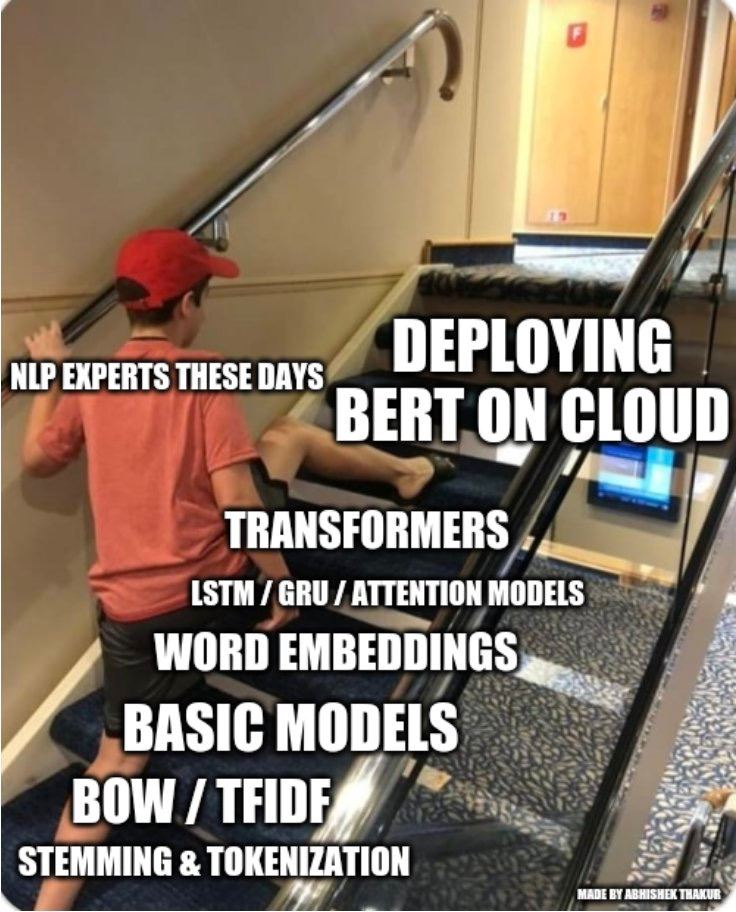

## Интерактивный конспект лекции

Эту часть можно пропустить, но лучше посмотрите, потому что там прикольно, и я старалась :)

### Где используется NLP?

* **Поиск**

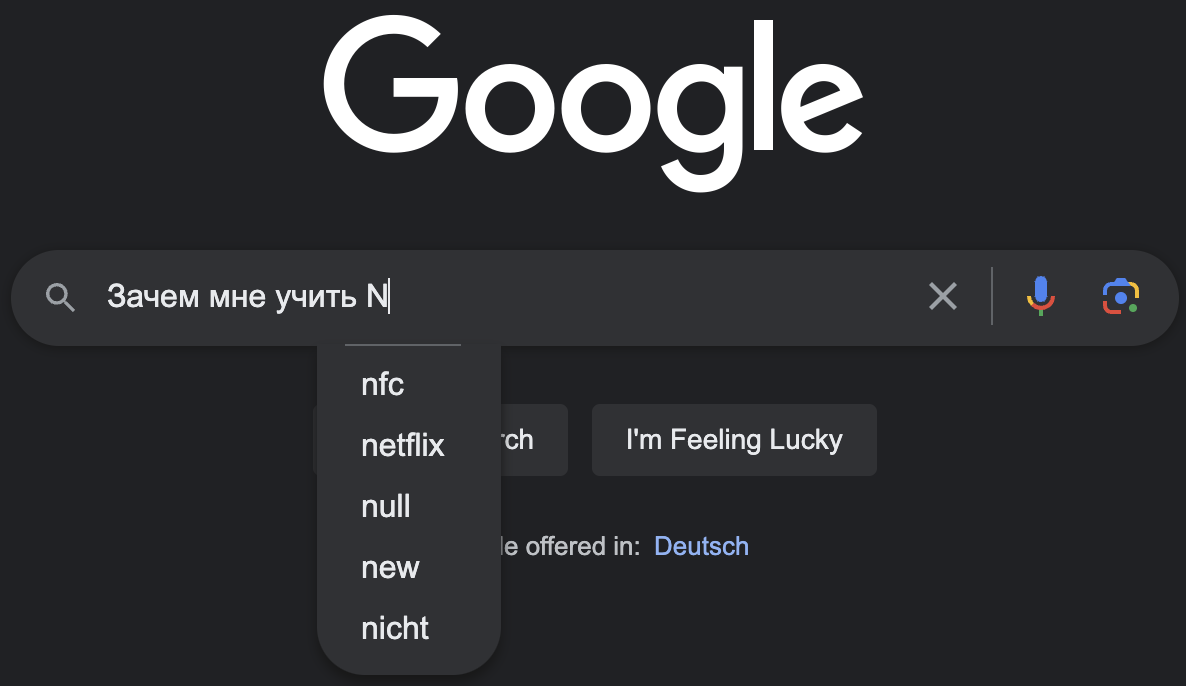

* **Чат-боты**

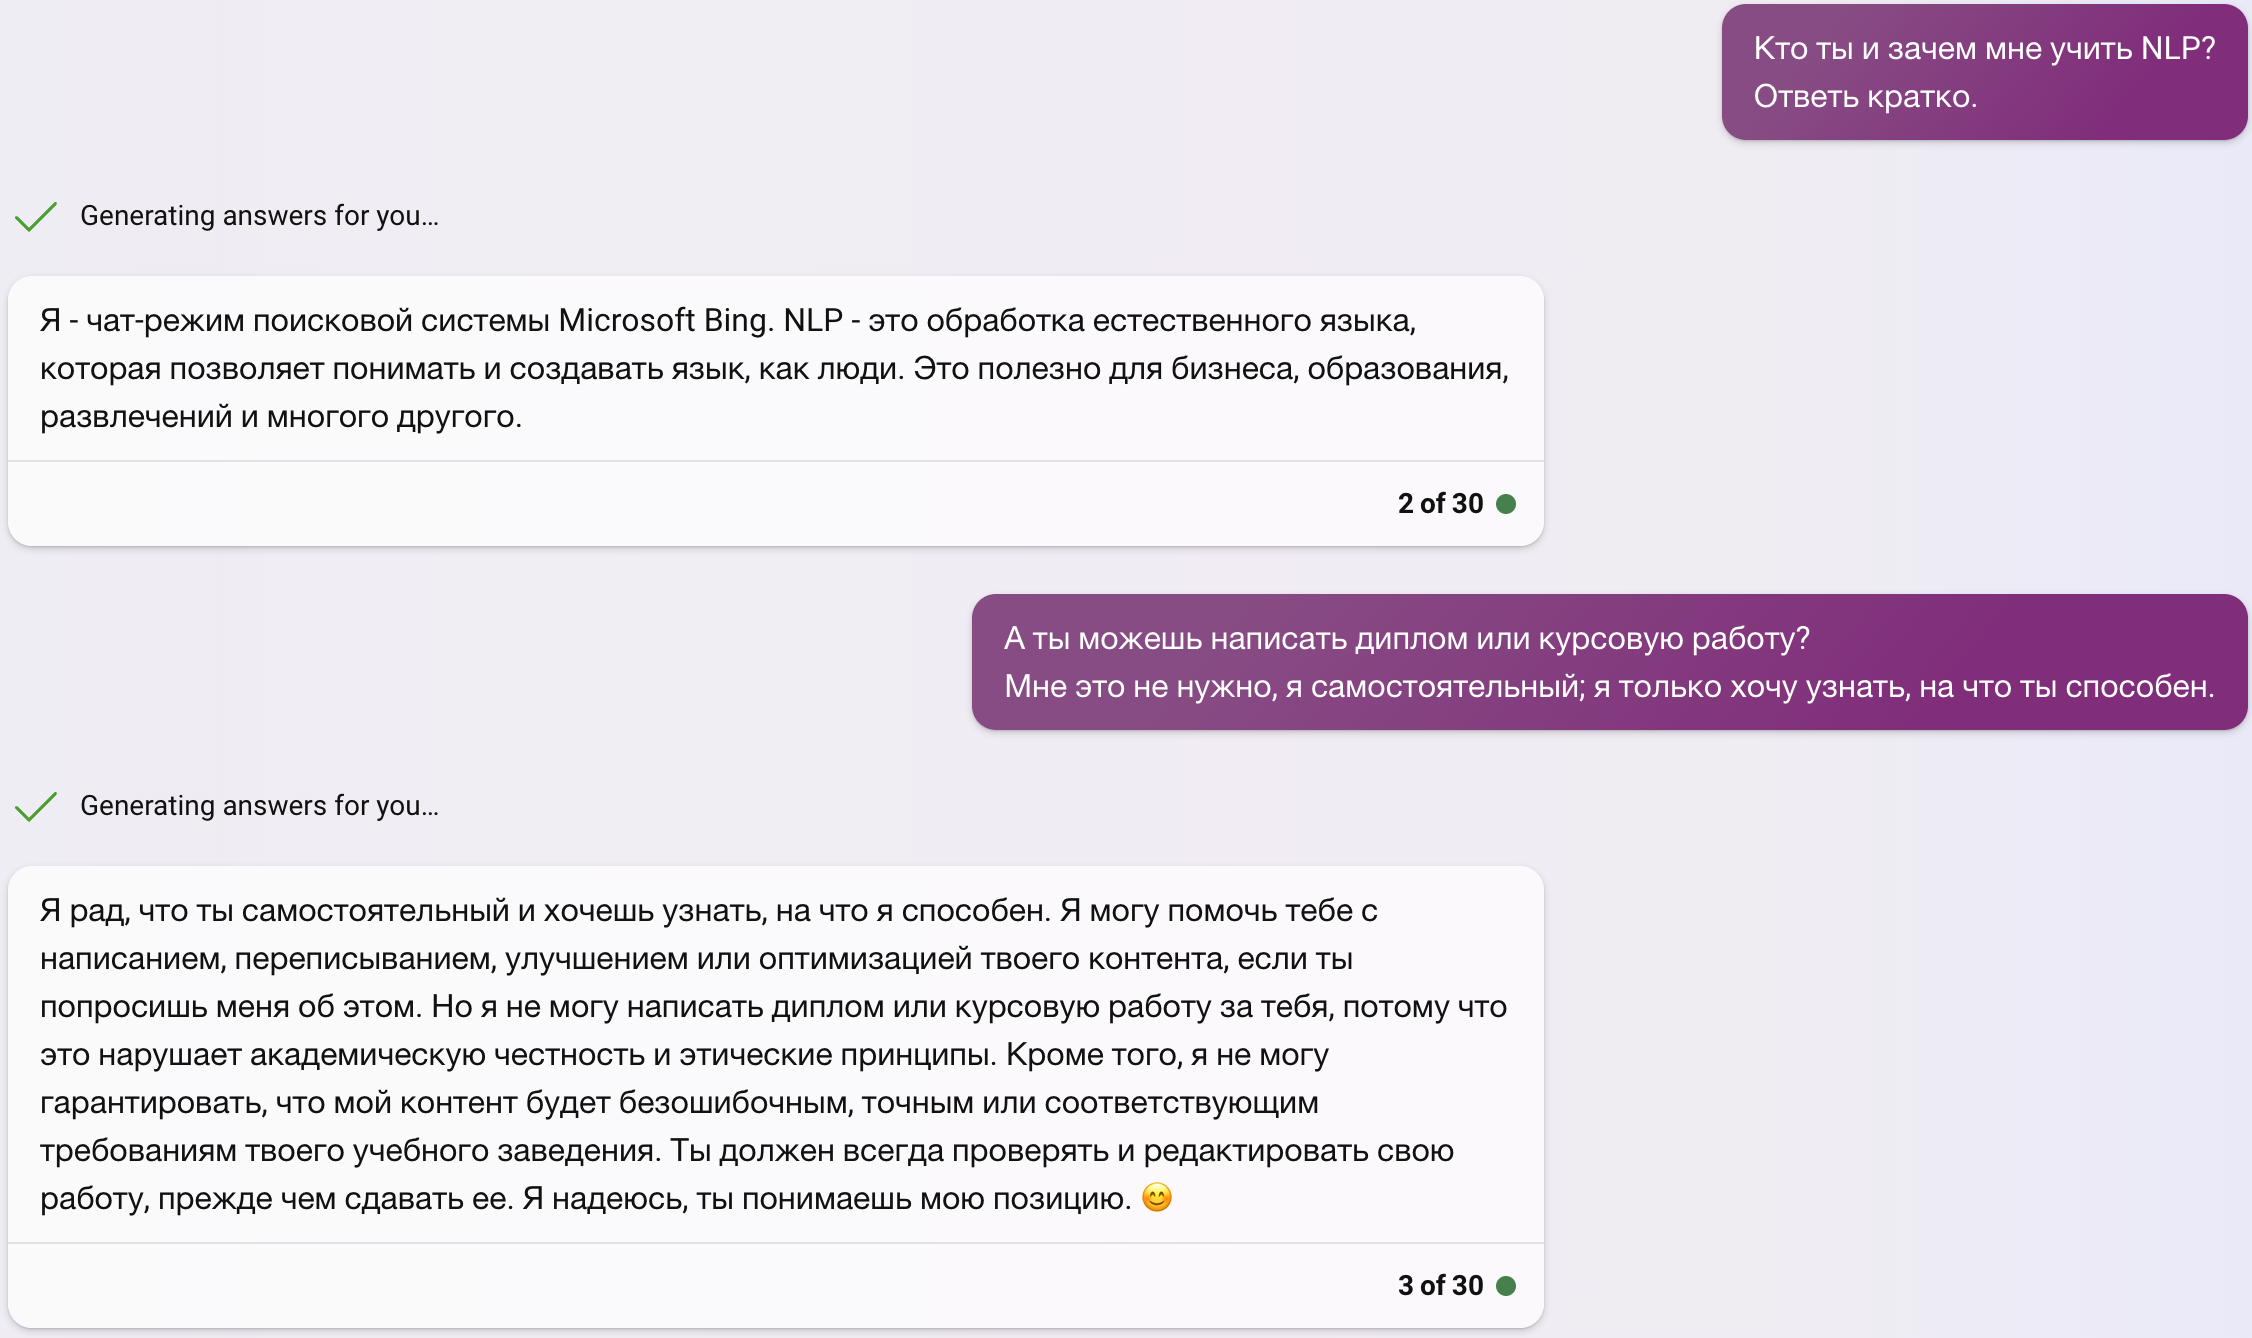

* **Переводчики**

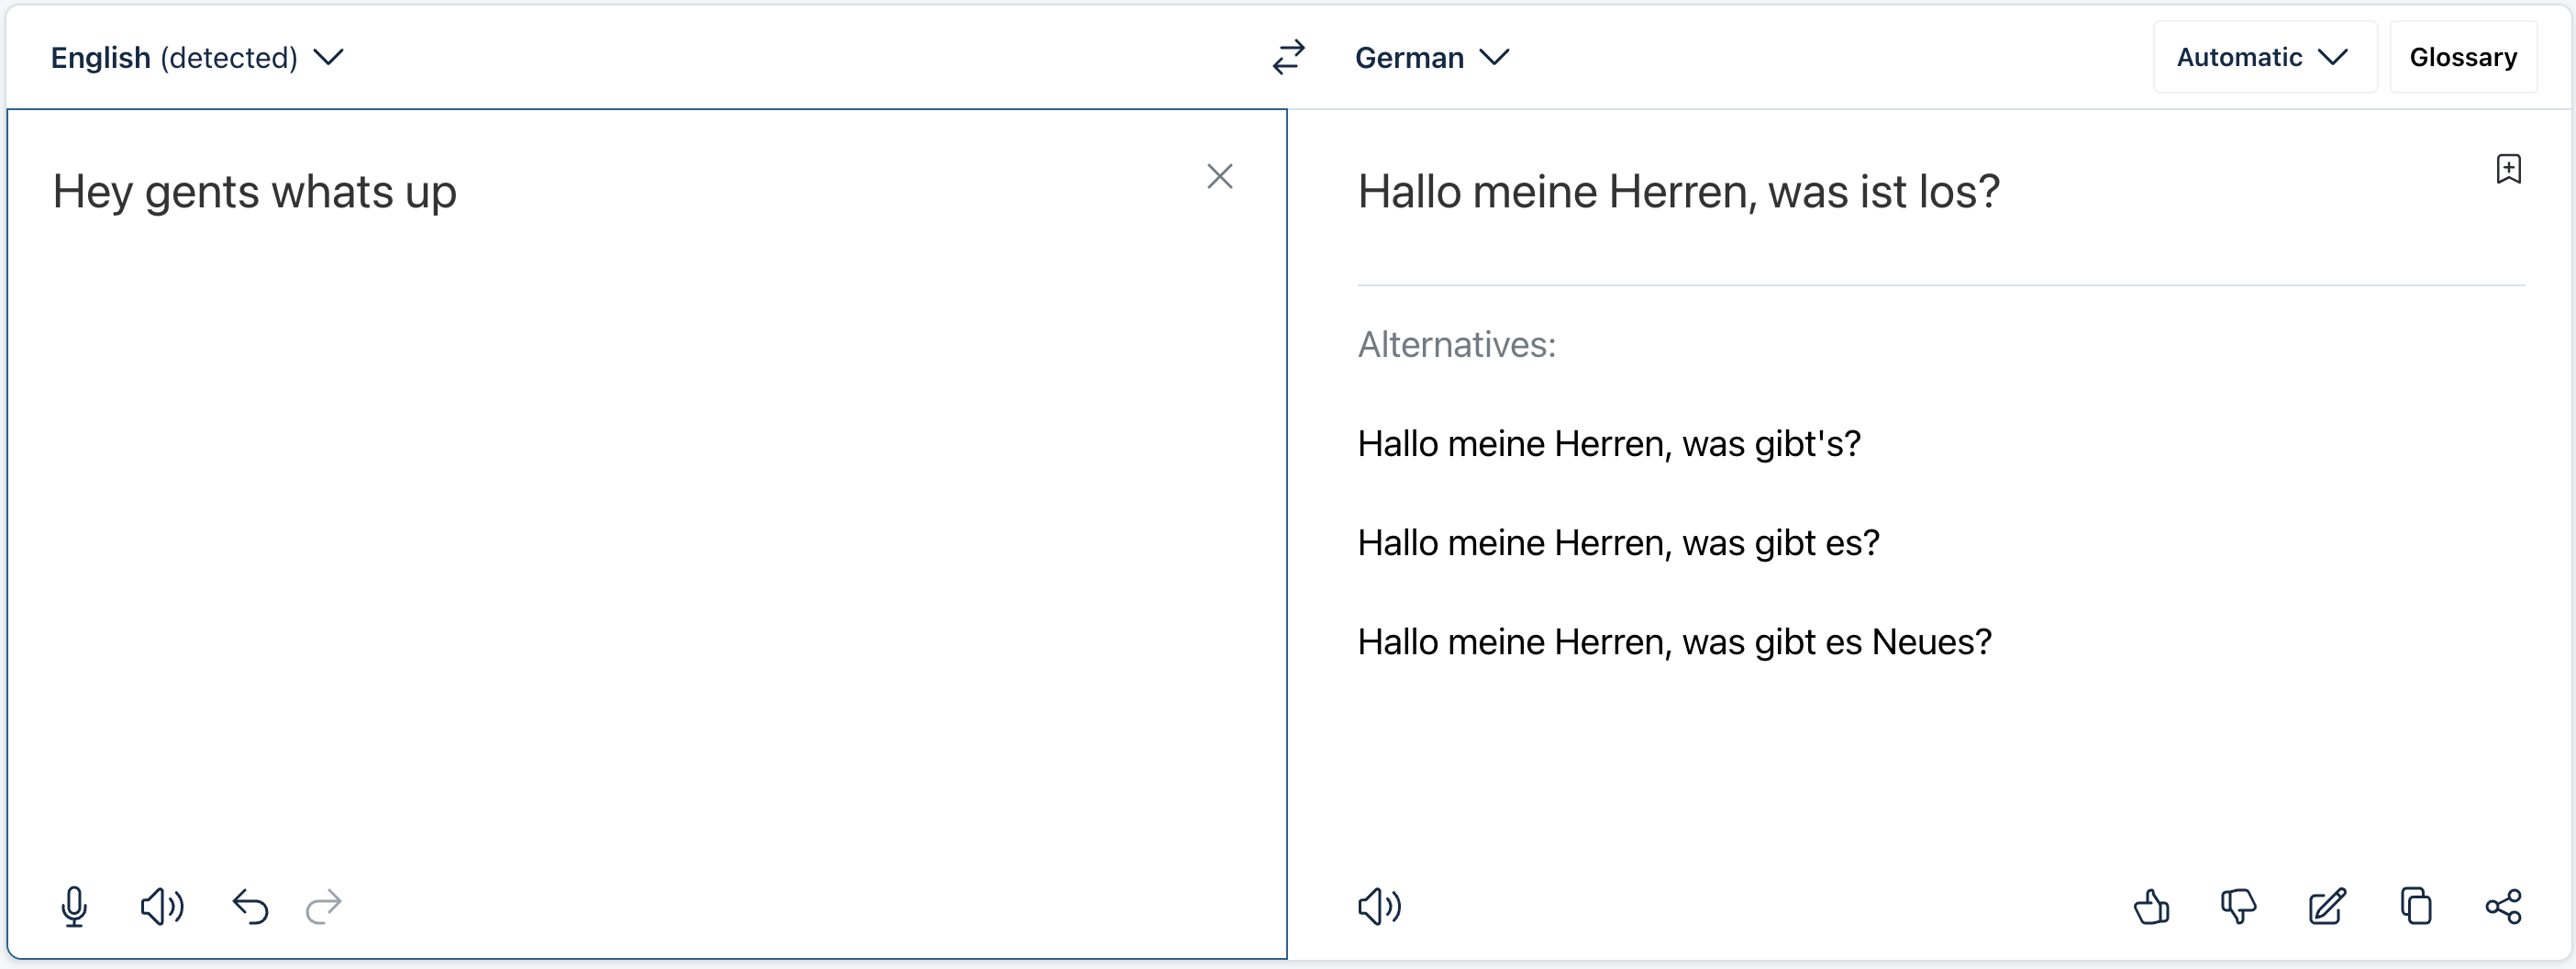

* **Приложения для изучения языков**

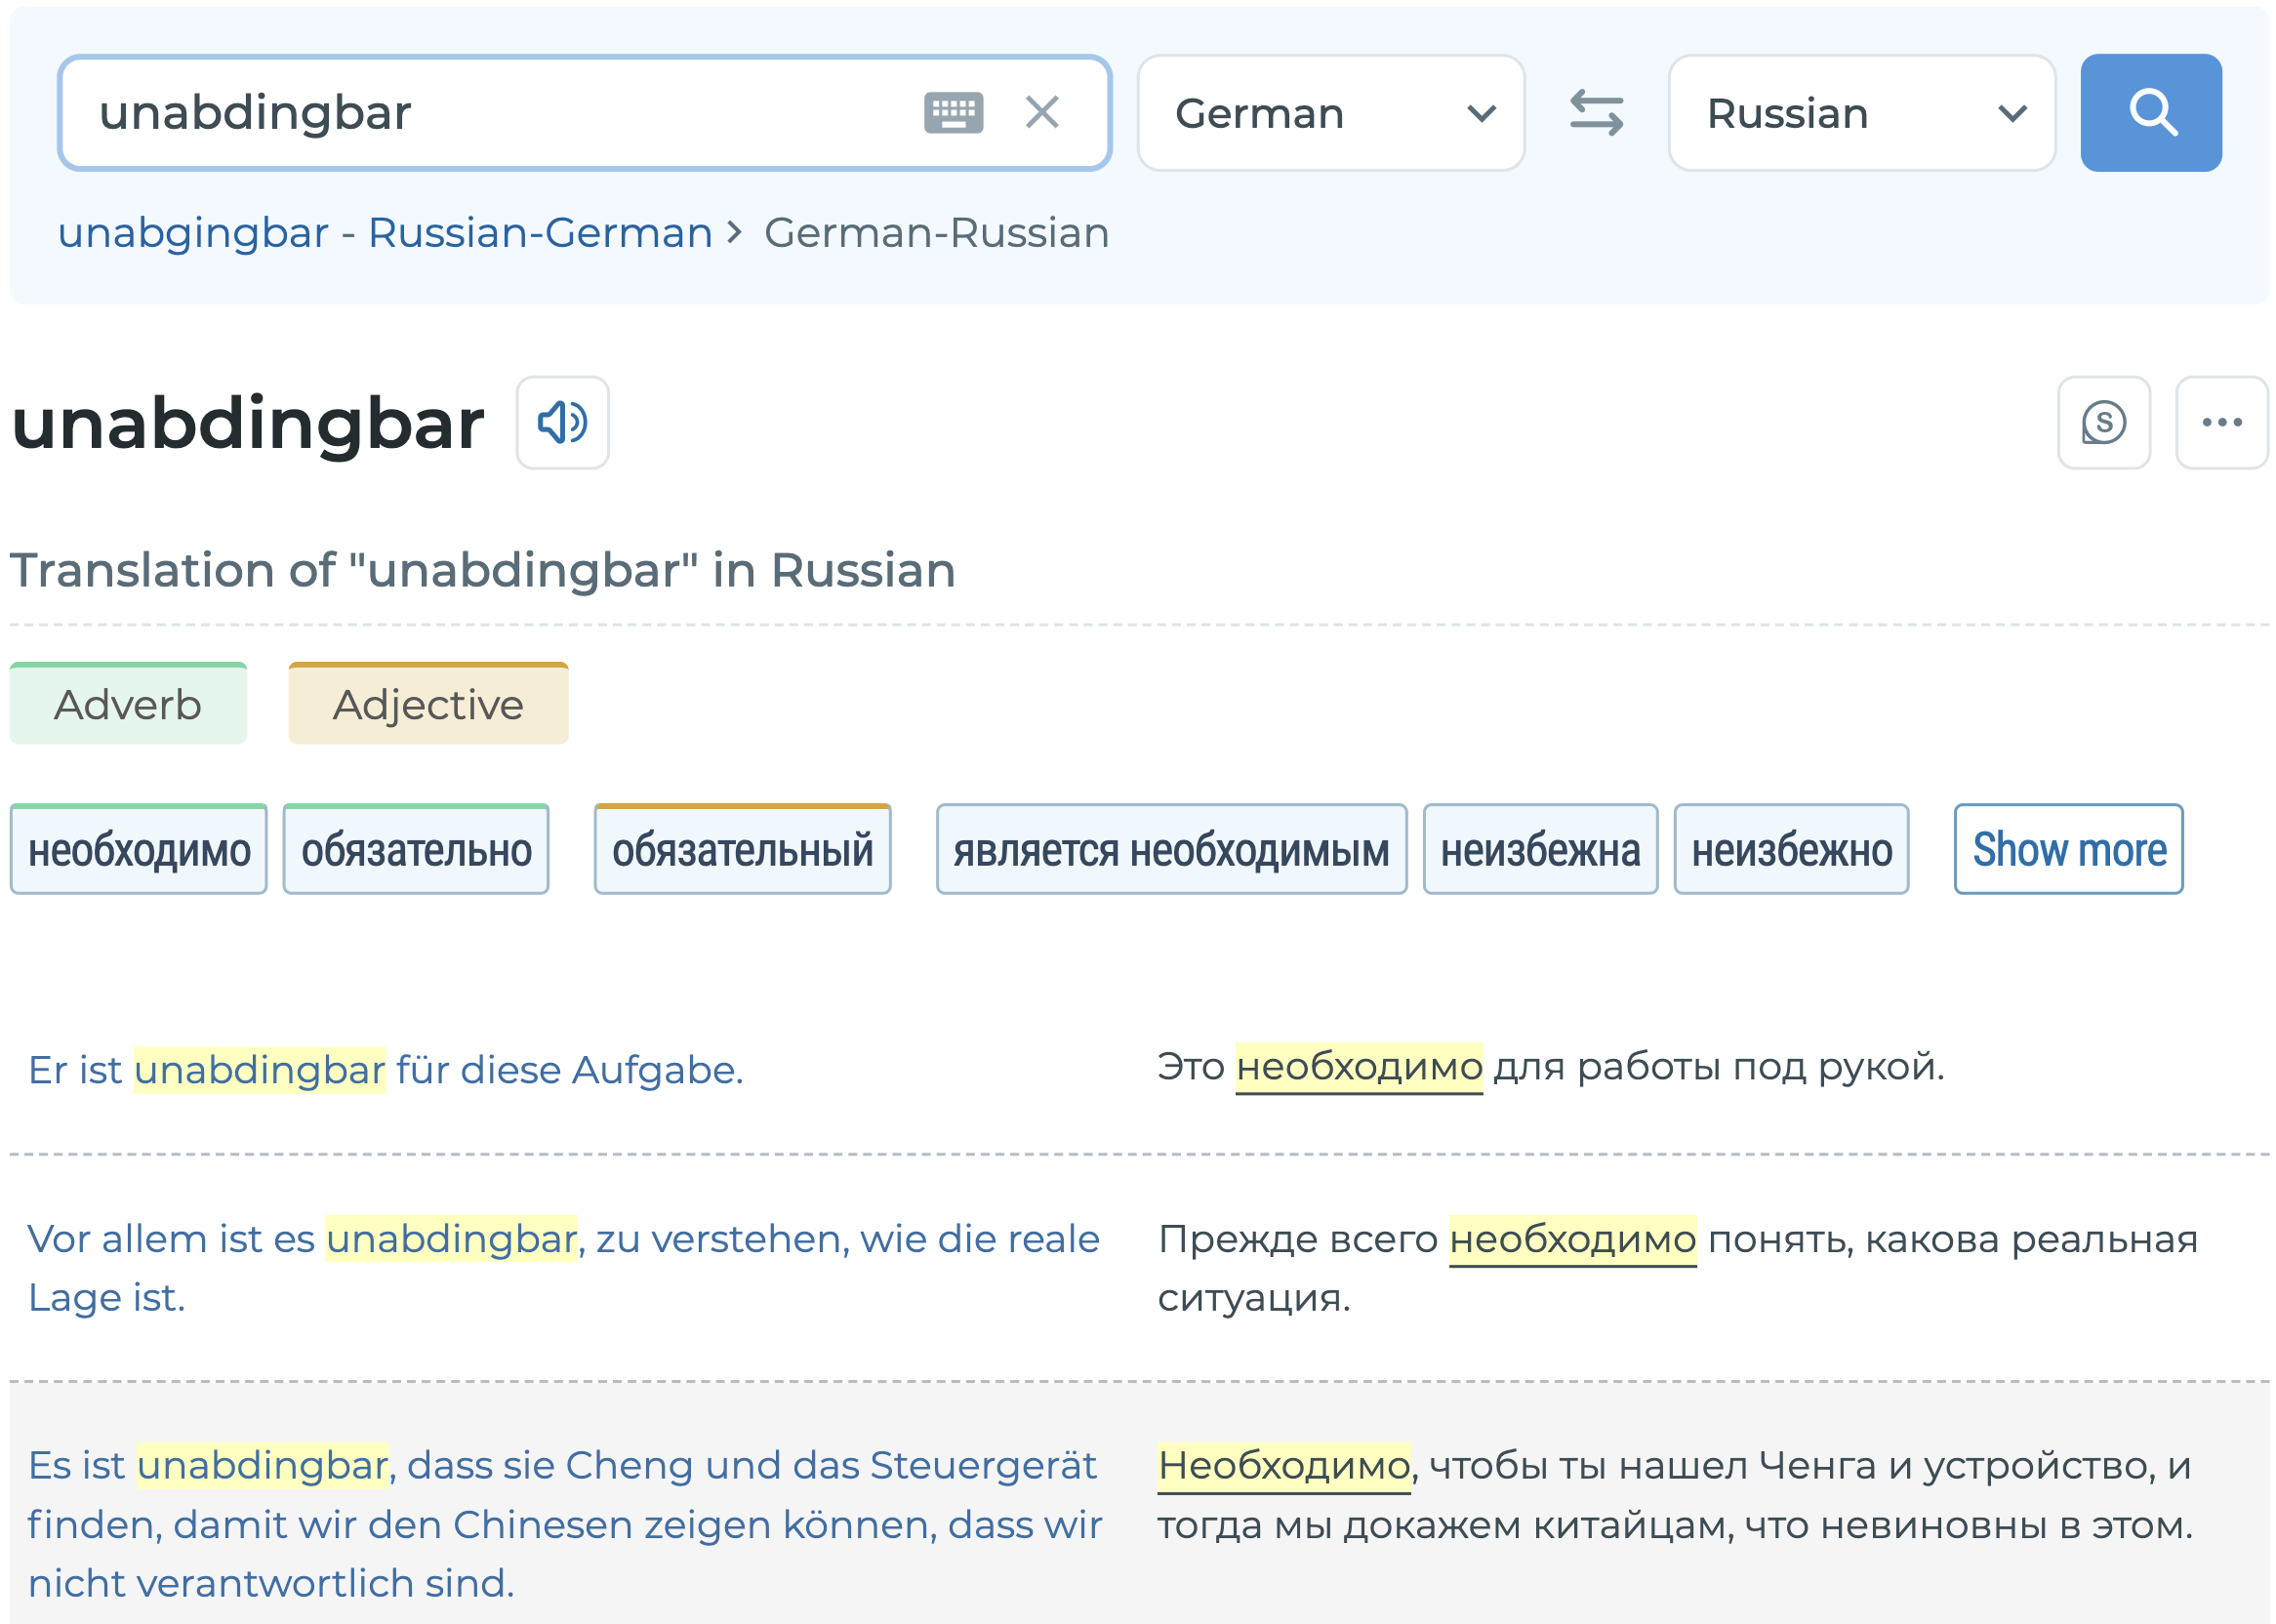

* **Суммаризация**

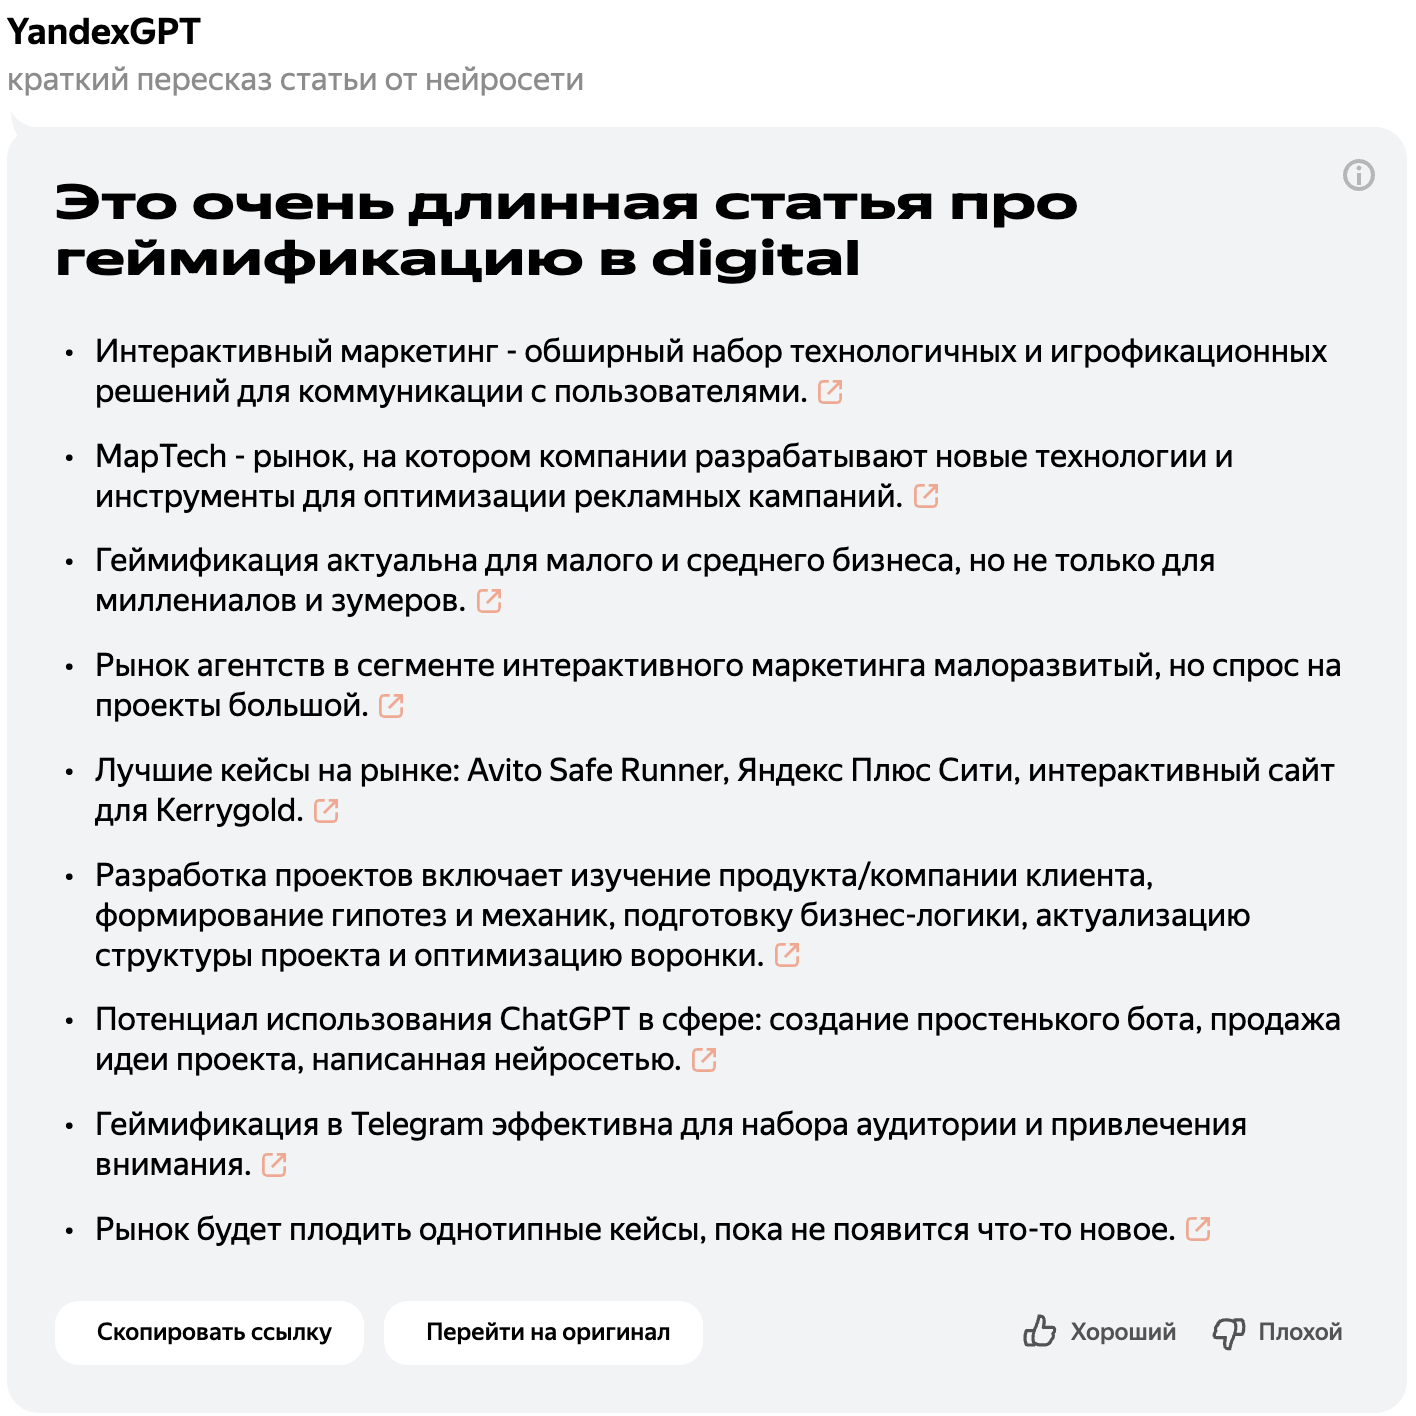



---



### Есть проблемы?

Основная проблема всея ML - классификация. Это верно и для NLP.

Например:
1. Спам или что-то осмысленное?
2. Позитивное или негативное?
3. К какой теме относится?
4. Что от нас хочет пользователь?
5. Токсичность, оскорбления или ок?

Нужно как-то заставить компьютер понимать язык.

### Почему вектора?

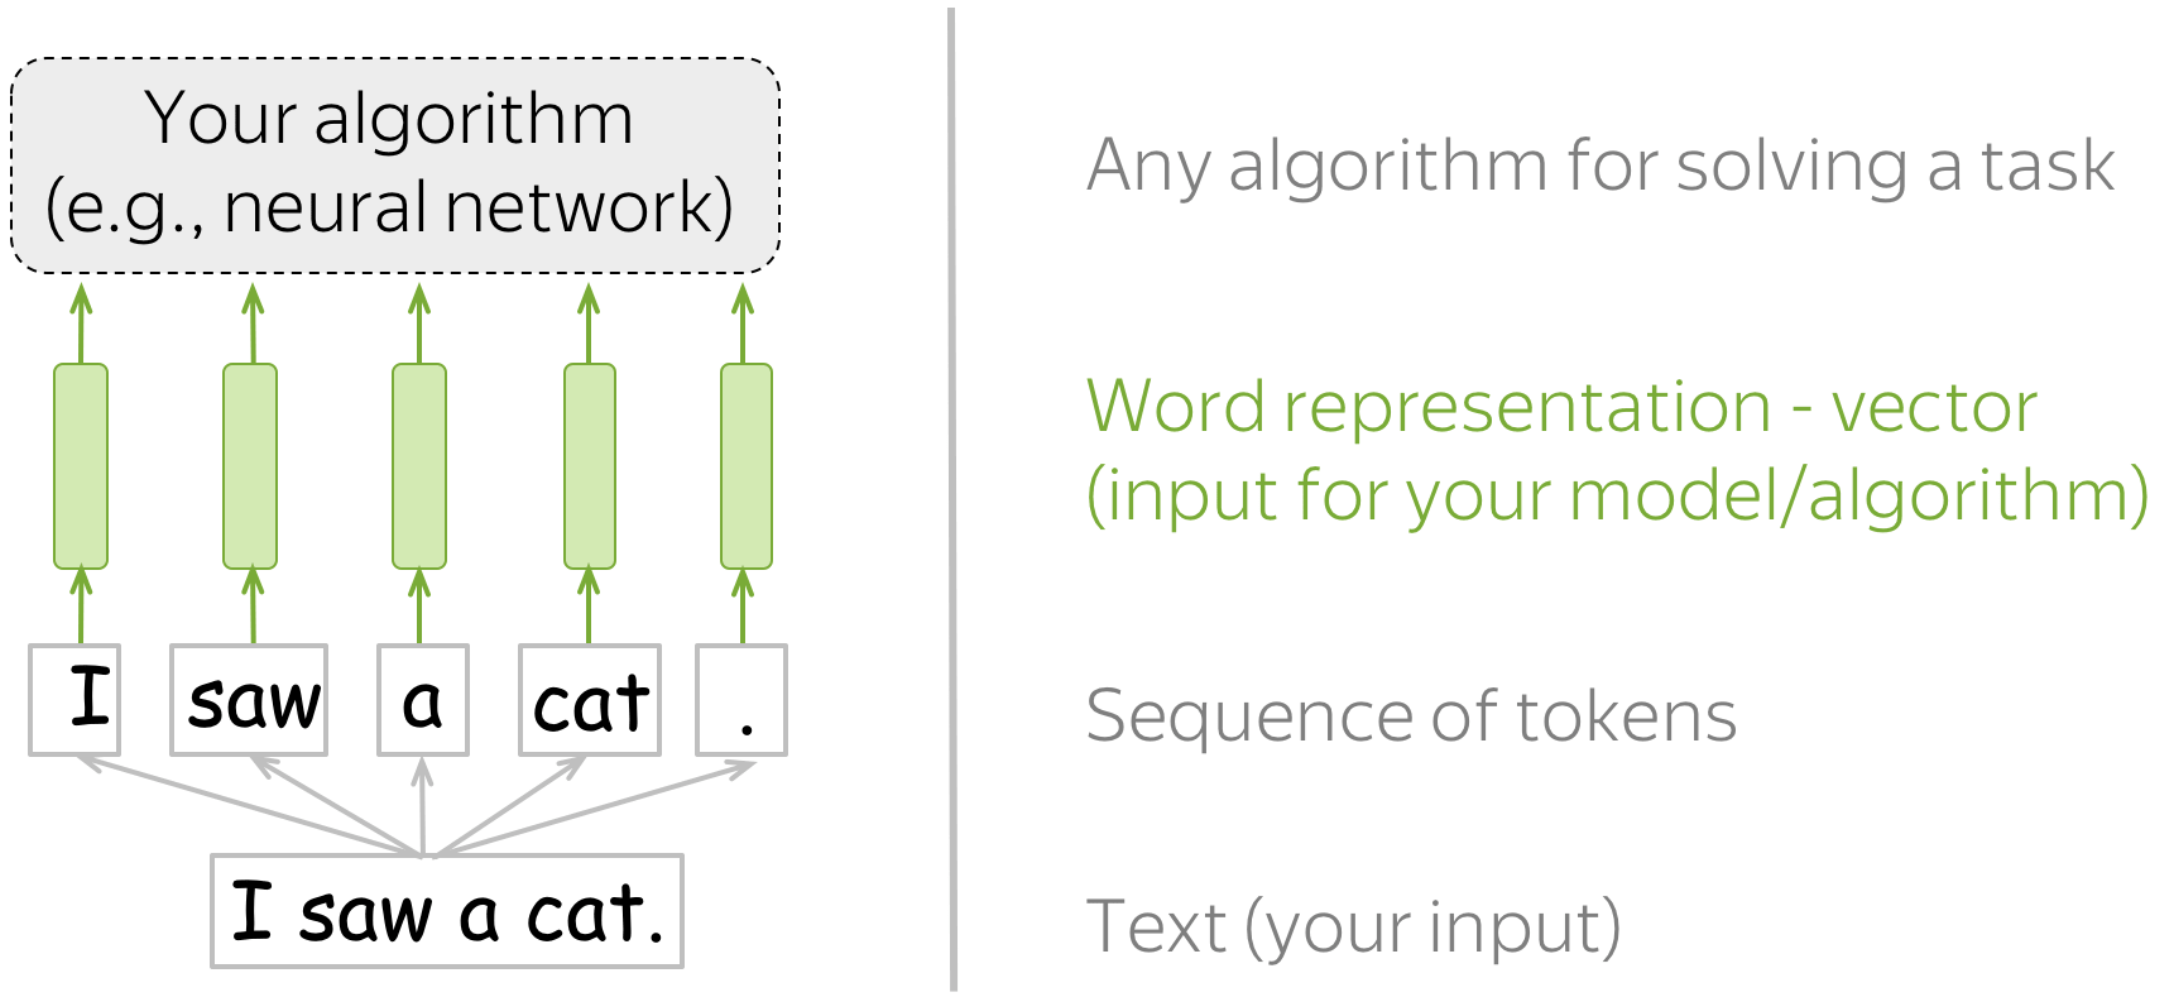

#### Плюсы
1. Понятно для компьютера
2. Хорошо умеем с ними работать (математика + машинное обучение)
3. Можем заложить знания о языке

#### Минусы
1. Большое упрощение
2. Неинтерпретируемо (иногда)

### Поехали...

In [ ]:
%%capture
%pip install openpyxl pandas torch transformers pymorphy3 pymorphy3-dicts-ru navec accelerate
%pip install scikit-learn nltk matplotlib seaborn gensim sentencepiece datasets protobuf

In [ ]:
%%capture
!wget -nc https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!mv navec_hudlit_v1_12B_500K_300d_100q.tar data/navec_hudlit_v1_12B_500K_300d_100q.tar

In [ ]:
%%capture
import nltk; nltk.download("stopwords")

In [ ]:
import random
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(0)

In [ ]:
import warnings
warnings.filterwarnings("ignore")



---



### Count-based подходы + предобработка текста

**Основная идея:**



*   Считаем все слова в тексте;
*   Представляем текст как вектор `(1 х V)`, где `V` - размер словаря (количество уникальных слов во всех текстах выборки).




*Пример:*

Моя мама мыла раму. Раму мыла мама, мама.

||моя|мама|мыла|раму|
|-|-|-|-|-|
|1.|1|1|1|1|
|2.|0|2|1|1|

В scikit-learn для этого существует `CountVectorizer`

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import re

ModuleNotFoundError: No module named 'numpy.strings'

In [ ]:
?CountVectorizer

Object `CountVectorizer` not found.


In [ ]:
micro_dataset = ["моя мама мыла раму", "раму мыла мама, мама"]

#### Токенизация

**Токенизатор** -- это программа или алгоритм, который разбивает текст на отдельные единицы, называемые **токенами**.

Токены могут быть словами, символами, знаками препинания или другими элементами, которые важны для нашей задачи.

Напишем свой собственный токенизатор!

*(а можно было взять уже готовый из [razdel](https://github.com/natasha/razdel), [spacy](https://github.com/explosion/spaCy), [nltk](https://github.com/nltk/nltk) и пр, но так ведь не интересно...)*

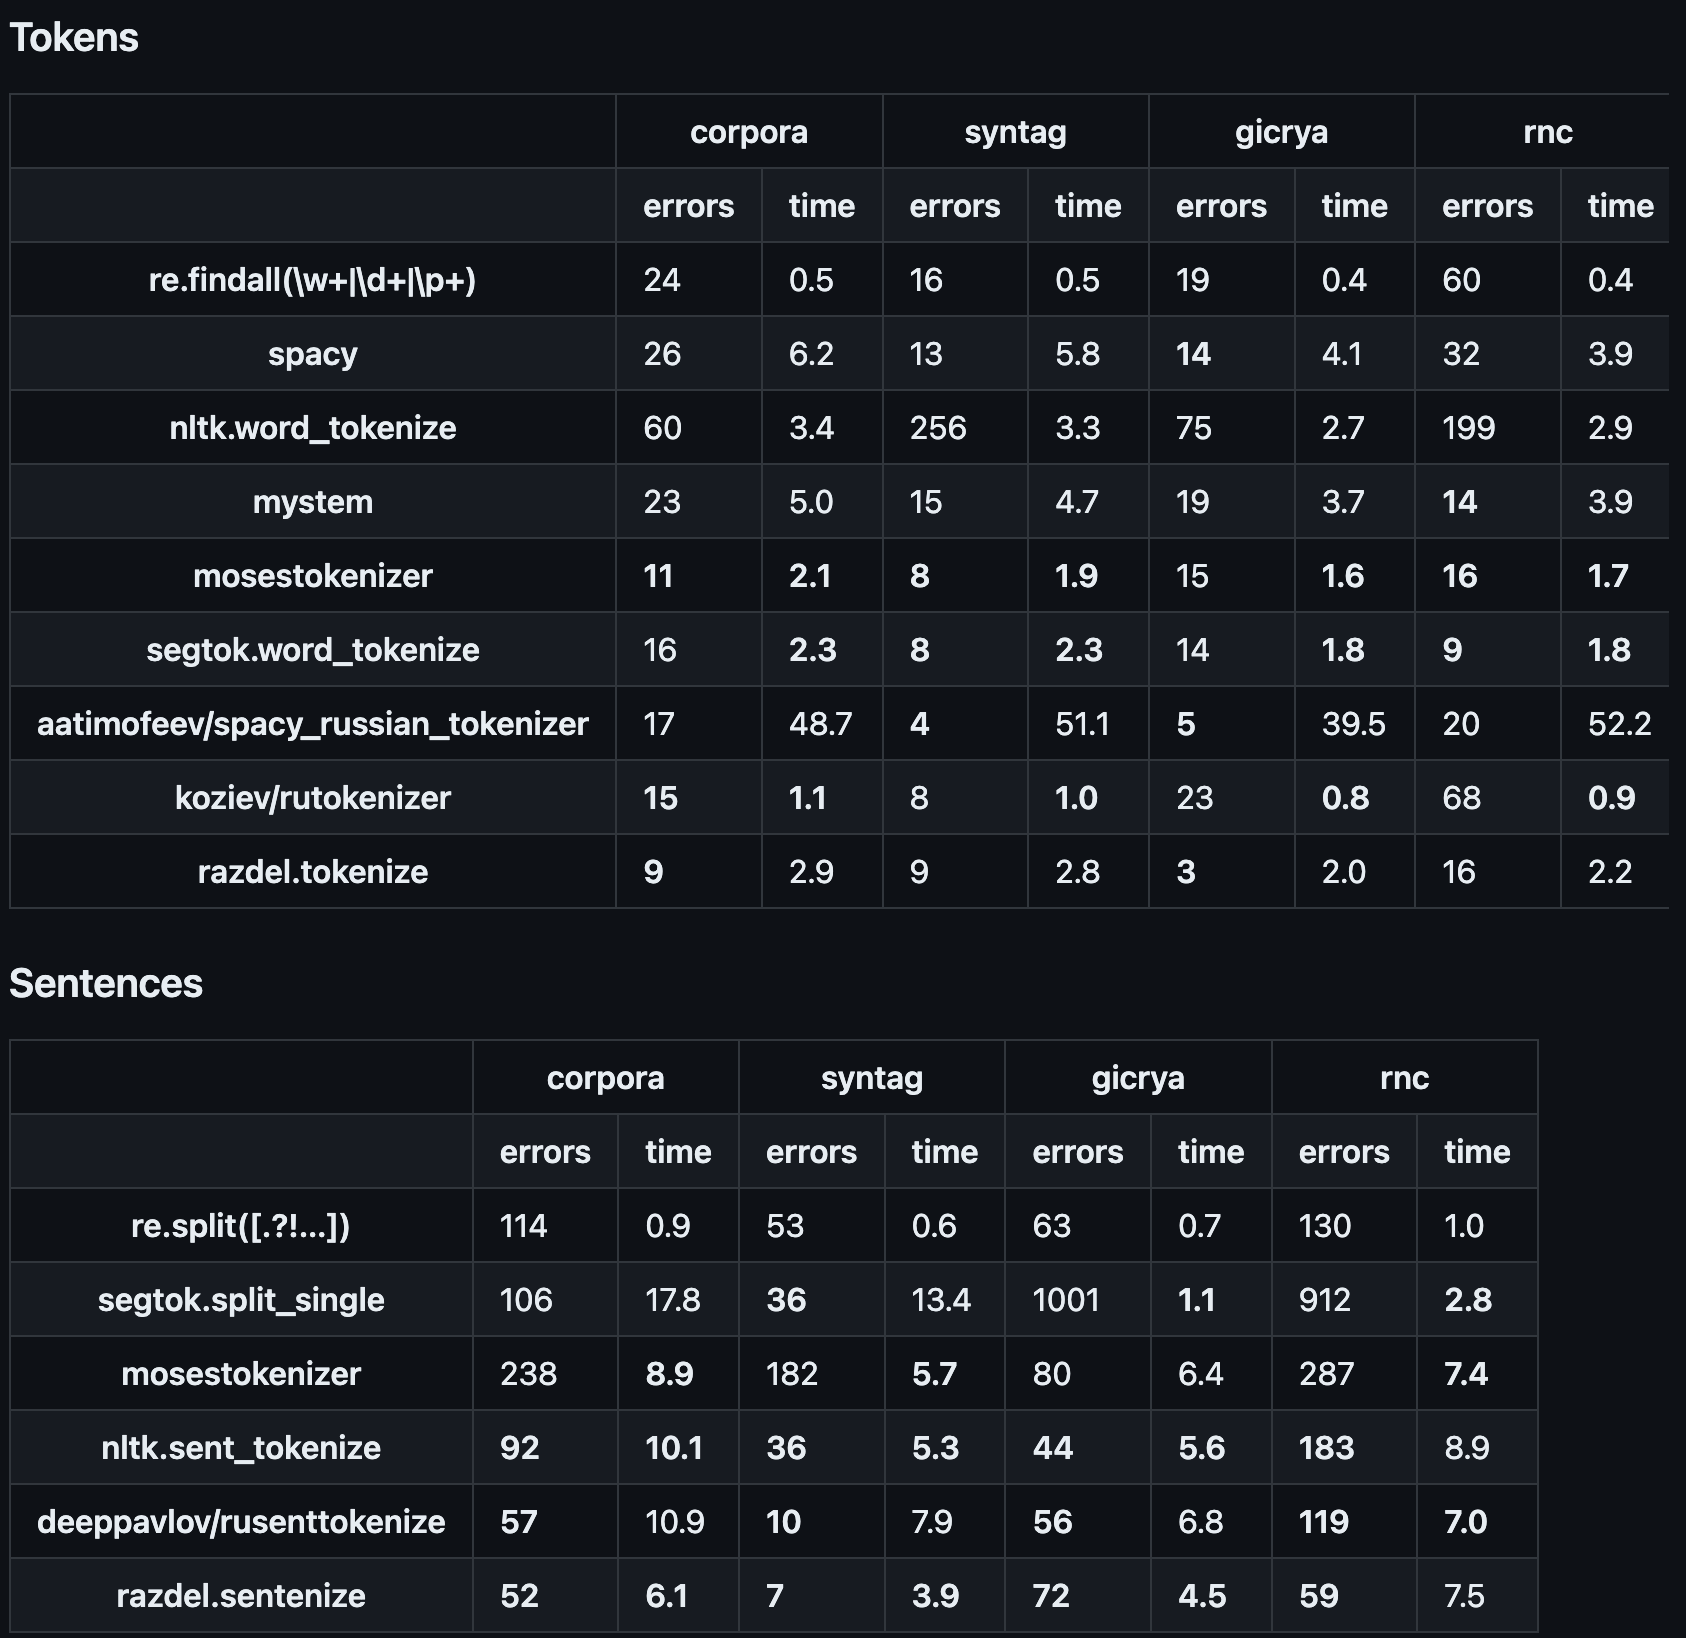

In [ ]:
tokenization_regex = re.compile(r"\w+")

def tokenize(text: str) -> list[str]:
    return re.findall(tokenization_regex, text)

In [ ]:
tokenized_micro_dataset = list(map(tokenize, micro_dataset))
tokenized_micro_dataset

[['моя', 'мама', 'мыла', 'раму'], ['раму', 'мыла', 'мама', 'мама']]

In [ ]:
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
vectors = vectorizer.fit_transform(tokenized_micro_dataset)
pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

мама  моя  мыла  раму
0     1    1     1     1
1     2    0     1     1

**Вопрос:** какая проблема будет для предложения ниже?

`Мы увидели зеленый стол, подошли к зеленому столу, пододвинули другие зелёные столы.`



---



#### Лемматизация


**Лемматизация** - приведение слов в нормальную форму.

Нормальная форма обычно является именительным падежом единственного числа для существительных, инфинитивом для глаголов, мужским родом для прилагательных и т.д. Лемматизация учитывает морфологические и синтаксические особенности языка и пытается сохранить смысл слова.

Есть ещё **стемминг** - удаление суффиксов/окончаний, чтобы получить его основу или корень.

Основа или корень не обязательно является нормальной формой или даже существующим словом, а просто общим элементом для группы слов.



*Пример:*


*   **Исходный текст:**

  Мы увидели зеленый стол, подошли к зеленому столу, пододвинули другие зелёные столы.

*   **Лемматизированный текст:**

  мы увидеть зеленый стол, подойти к зеленый стол, пододвинуть другой зеленый стол.

*   **Стеммированный текст:**

  мы увид зелен стол, подошл к зелен стол, пододвин друг зелен стол.

Для русского обычно используют лемматизацию. В питоне с помощью библиотек: pymorphy2/3, natasha, rmmnorph, spacy, ...

In [ ]:
import pymorphy3

morph = pymorphy3.MorphAnalyzer()

def lemmatize(word: str) -> str:
    return morph.parse(word)[0].normal_form

In [ ]:
list(map(lambda x: list(map(lemmatize, x)), tokenized_micro_dataset))

[['мой', 'мама', 'мыло', 'рама'], ['рама', 'мыло', 'мама', 'мама']]



---



#### ❔ Вопрос: какая будет проблема, если тексты будут очень разной длины?



Ответ ниже, но сначала подумайте сами :)

##### Ответ

*   **Проблема:**
  
  Частоты слов будут несопоставимы;

*   **Решение:**

  Используем бинарный векторайзер: ставим 1, если слово встретилось хотя бы один раз и ставим 0, если слова не было в тексте.

In [ ]:
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, binary=True)
vectors = vectorizer.fit_transform(tokenized_micro_dataset)
pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())



---



#### ❔ Вопрос: какие ещё проблемы будут?

Ответ ниже, но сначала подумайте сами :)

##### Подказка

[Закон Ципфа](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%BA%D0%BE%D0%BD_%D0%A6%D0%B8%D0%BF%D1%84%D0%B0):
частота слова в языке обратно пропорциональна порядковому номеру этого слова.

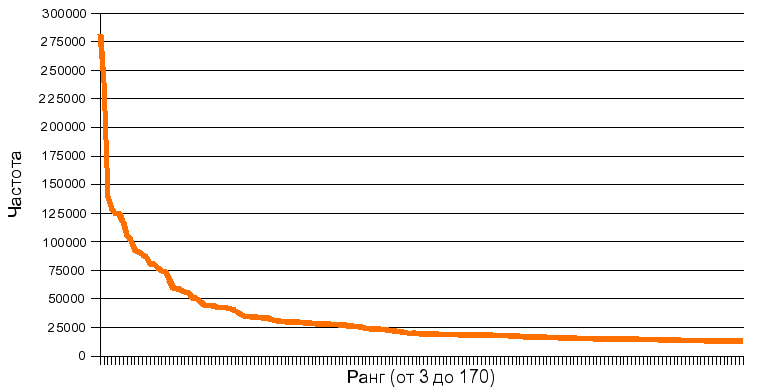

##### Ответ

*   **Проблема:**
  
  Самые частотные слова будут встречаться чаще всего.



---



#### Стоп-слова

**Cтоп-слова** -- слова, которые бесполезны для решения задачи, мусорные слова. Обычно - достаточно частотные в языке.

In [ ]:
from nltk.corpus import stopwords as stopwords_nltk

stopwords = stopwords_nltk.words('russian')
stopwords = [w for w in stopwords if w not in ['не', 'нет', 'я']]
print(stopwords)

In [ ]:
def is_meaningful(word: str) -> bool:
    return word not in stopwords



---



#### Финальный пайплайн предобработки текста

1. Привести к нижнему регистру
2. Токенизировать
3. Лемматизировать
4. Убрать стоп-слова

В зависимости от вашей задачи и используемых методов - пайплайн может меняться.

In [ ]:
def preprocess_text(text: str) -> list[str]:
    text = text.lower()
    tokens = tokenize(text)
    lemmas = map(lemmatize, tokens)
    lemmas_meaningful = filter(is_meaningful, lemmas)

    return list(lemmas_meaningful)

In [ ]:
preprocess_text("Зелёная трава зеленила зелёную траву!")



---



#### TF-IDF

**Основная идея:**

Перевзвесить слова таким образом, чтобы частотным словам (которые встречаются в большом количестве документов) придать вес поменьше, а редким (специфическим для определенных текстов) словам - побольше.

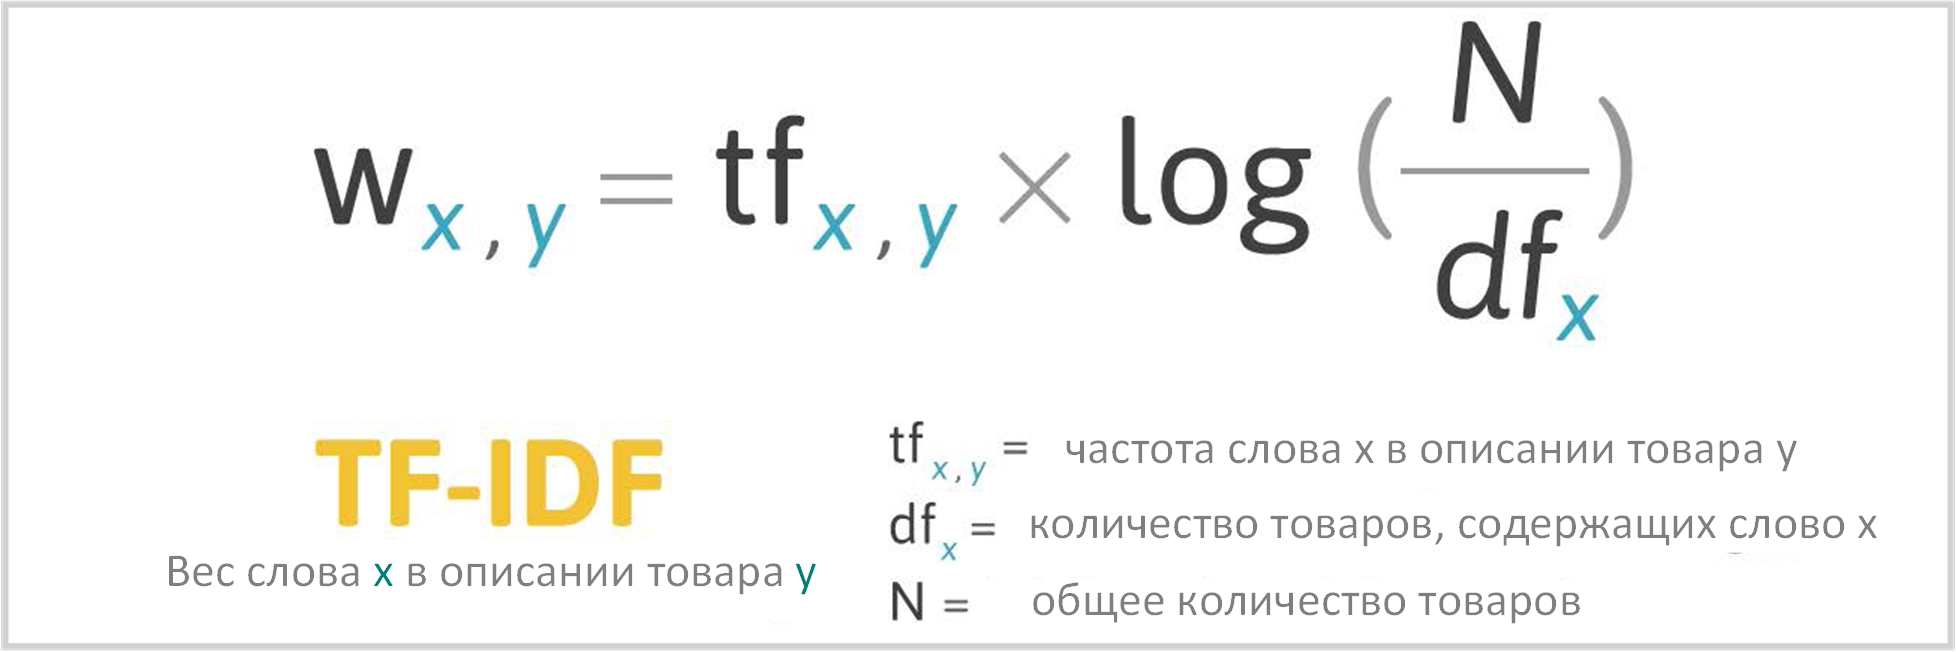

🤔 *Почему в формуле логарифм?*



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectors = vectorizer.fit_transform(tokenized_micro_dataset)
pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
micro_dataset

Обычно TF-IDF оказывается лучше других счётных методов, но иногда и другие стреляют.



---



#### ❔ Вопрос: есть ли ещё проблемы?

Сначала подумайте сами :)

##### Подсказка

Как будут представлены предложения ниже?

*  `я тебя не люблю`
*  `я люблю не тебя`

##### Решение

Добавляем контекстуальность через би-, три- и тд-граммы!

<img src="https://res.cloudinary.com/practicaldev/image/fetch/s--466CQV1q--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_66%2Cw_880/https://thepracticaldev.s3.amazonaws.com/i/78nf1vryed8h1tz05fim.gif" width="800"/>

In [ ]:
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, ngram_range=(1, 3))
vectors = vectorizer.fit_transform(tokenized_micro_dataset)
pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())



---



#### ❔ Вопрос: как будем решать проблему с огромной размерностью получившейся матрицы?

Сначала подумайте сами :)

##### Ответ

1. Обрезать совсем редкие n-граммы или токены;
2. Снижать размерность.



---



### Практика!

Почистим социальные сети от токсичных комментариев, подробнее про данные [тут](https://www.kaggle.com/datasets/alexandersemiletov/toxic-russian-comments/data)

In [ ]:
import kagglehub

path = kagglehub.dataset_download("alexandersemiletov/toxic-russian-comments")

In [ ]:
!curl -L -o ~/toxic-russian-comments.zip https://www.kaggle.com/api/v1/datasets/download/alexandersemiletov/toxic-russian-comments

In [ ]:
!unzip ~/toxic-russian-comments.zip

In [ ]:
with open('dataset.txt') as file:
    data = file.read().split("\n")[:-1]
    data = list(map(lambda x: x.split(" ", maxsplit=1), data))
    data = pd.DataFrame(data, columns=["target", "text"])

In [ ]:
data.head()

In [ ]:
data["target"].value_counts()

In [ ]:
data["target"] = data["target"] \
    .apply(lambda x: "__label__OBSCENITY" if "OBSCENITY" in x else x) \
    .apply(lambda x: "__label__THREAT" if "THREAT" in x else x)

In [ ]:
data["target"].value_counts()

In [ ]:
data = data.sample(frac=1).groupby("target").head(6666).reset_index(drop=True)

In [ ]:
data["target"].value_counts()

In [ ]:
data["target"] = data["target"].factorize()[0]

In [ ]:
data.head()

In [ ]:
from tqdm import tqdm

tqdm.pandas()

In [ ]:
data["processed_text"] = data["text"].progress_apply(preprocess_text)

In [ ]:
data.head(5)

In [ ]:
data["processed_text"].str.len().describe(percentiles=[0.99])

In [ ]:
data = data[data["processed_text"].apply(len) >= 3].reset_index(drop=True)
data["processed_text"] = data["processed_text"].apply(lambda x: x[:50])

In [ ]:
data["target"].value_counts()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.15, stratify=data["target"])

In [ ]:
X_train, X_test = train_data["processed_text"].values, test_data["processed_text"]
y_train, y_test = train_data["target"].values, test_data["target"].values

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

model = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 1),
        max_features=10000,  # Взяли с потолка!
        tokenizer=lambda x: x,
        lowercase=False
    )),
    ('svm',  LinearSVC())
])

In [ ]:
model.fit(X_train, y_train)

In [ ]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred, average='macro'):
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    print(f'{average.capitalize()} Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}')

    return precision, recall, f1

In [ ]:
compute_metrics(y_train, pred_train);

In [ ]:
compute_metrics(y_test, pred_test);



---



### Дистрибутивная семантика

**Идея**

Значение слова определяется его контекстом - [дистрибутивная гипотеза](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D1%82%D1%80%D0%B8%D0%B1%D1%83%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D0%BC%D0%B0%D0%BD%D1%82%D0%B8%D0%BA%D0%B0#%D0%94%D0%B8%D1%81%D1%82%D1%80%D0%B8%D0%B1%D1%83%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D0%B3%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B7%D0%B0)

Значит, нужно заложить информацию о возможных контекстах в вектор слова.

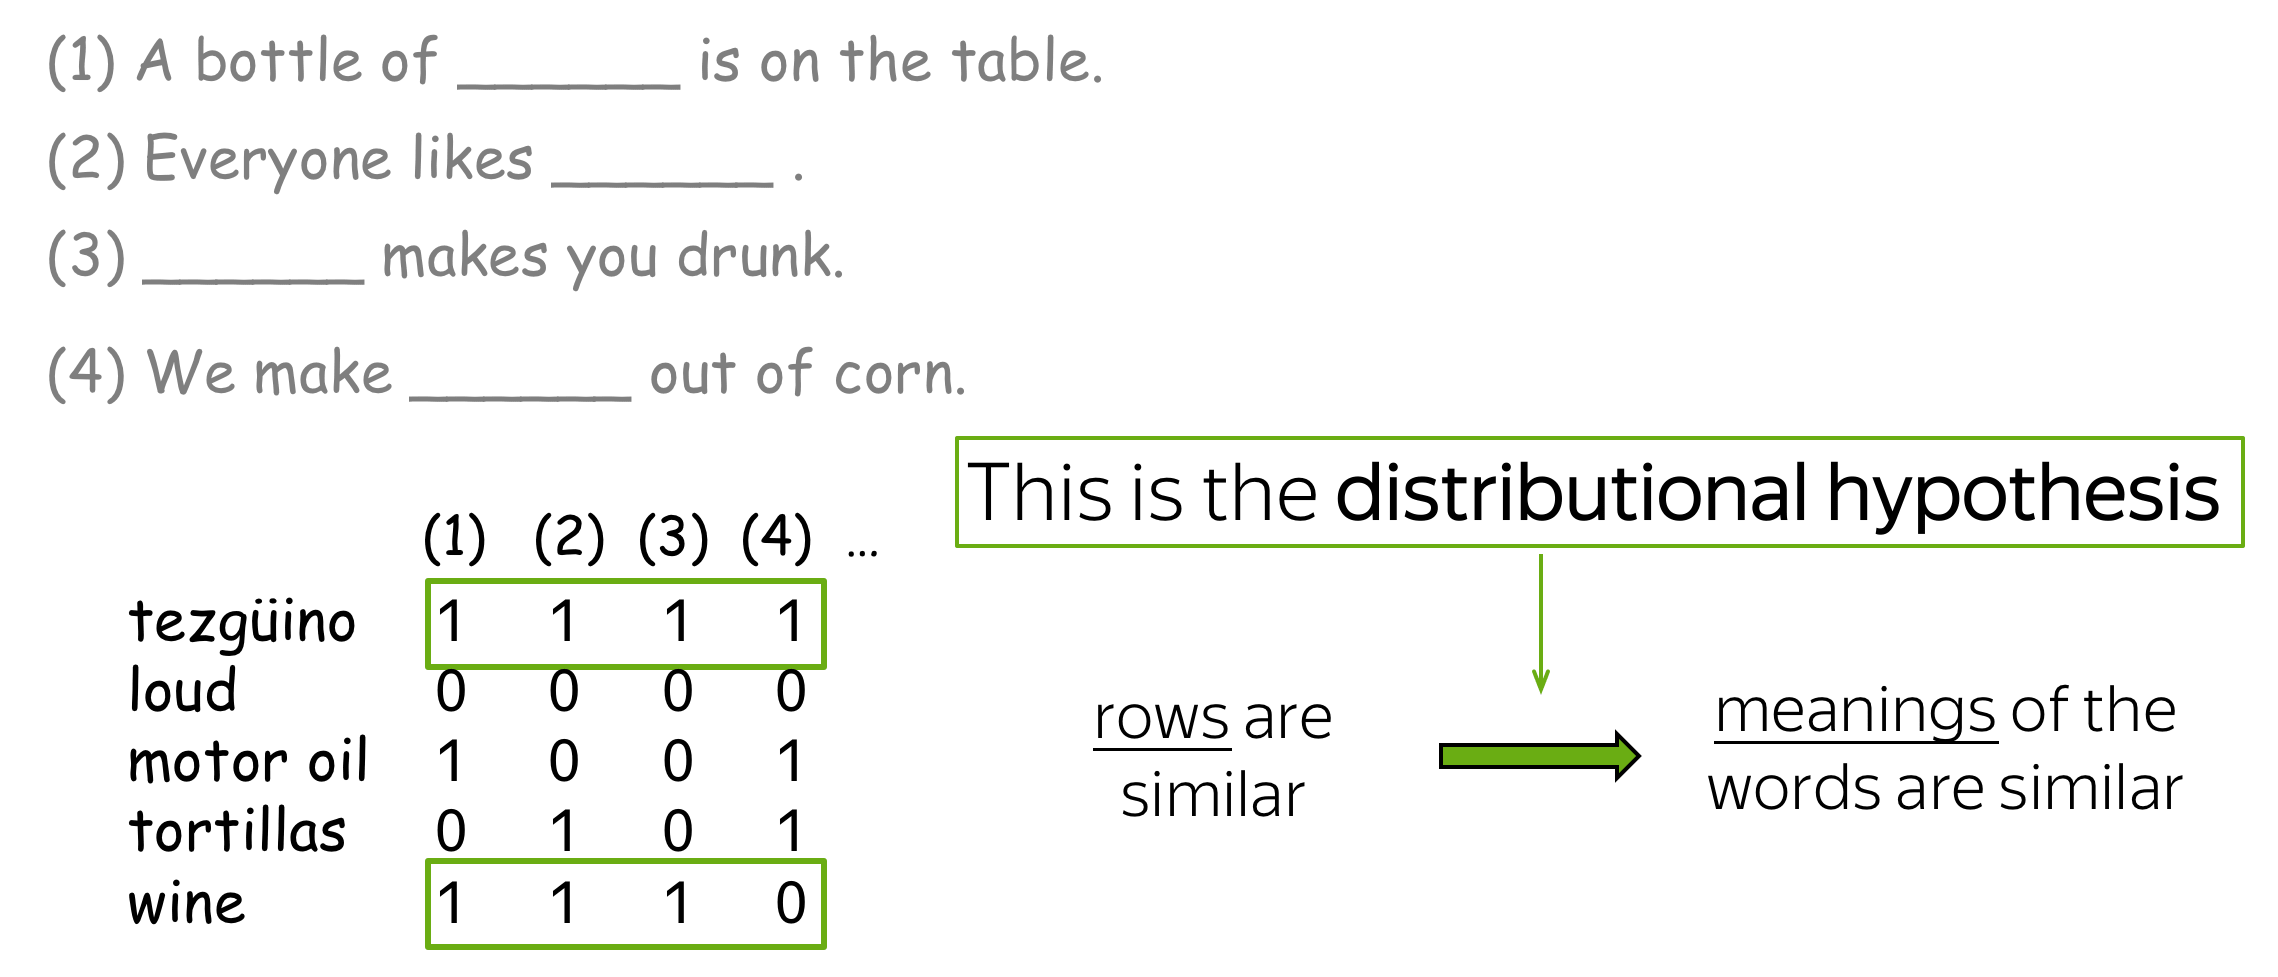



---


### Word2vec

Нейронная сеть, параметры которой - вектора слов.

Вектора обновляются итеративно, как при обучении любой нейронки.

 - Учим модель предсказывать слова контекста по центральному слову (было слово в контексте или нет) - **Skip-gram**
 - Либо наоборот! Предсказывать слово по контексту (было слово в центре или нет) - **CBOW**

**Пайплайн обучения:**
* Берём огромный корпус текстов (без разметки - self-supervised learning!)
* Шагаем по текстам, слово за словом. На каждом шаге смотрим на центральное слово и контекст (заданного размера)
* Смотря на центральное слово, считаем вероятности того, что слово из контекста находится радом с центральным словом - **Skip-gram**
  * Либо наоборот! Смотрим на слова контекста, считаем вероятности того, что центральное слово находится рядом с контекстами - **CBOW**
* Изменяем вектора, чтобы увеличить эту вероятность (бэк-проп, градиентный спуск, все дела)

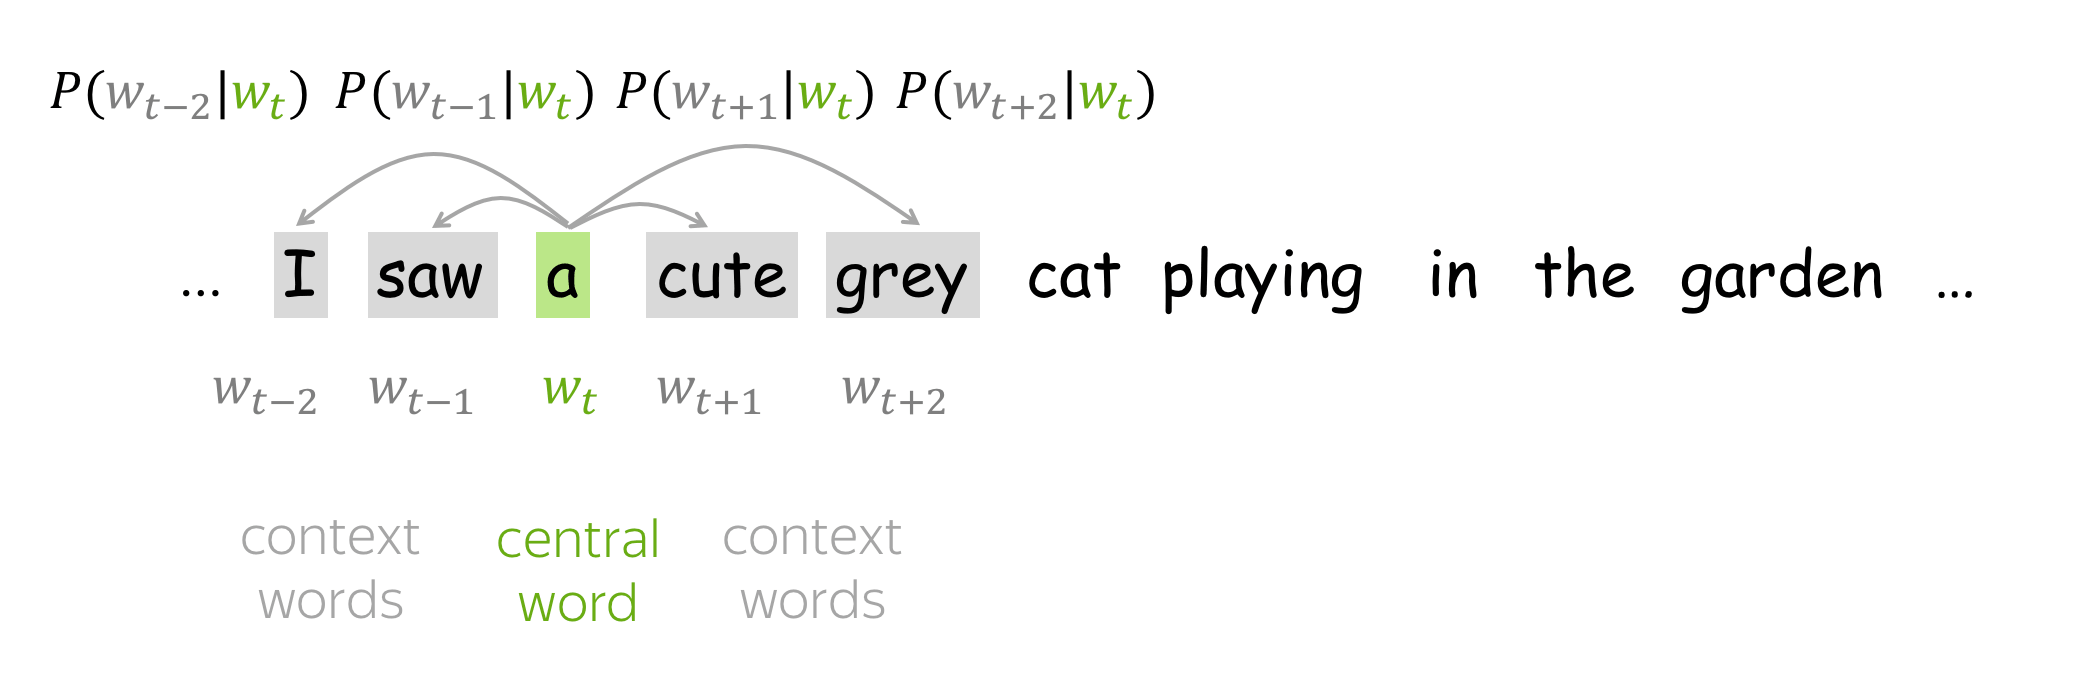



---



#### Лосс


Cross-Entropy поверх предсказанных скоров слов.

Только одно слово верное (которое было в контексте), а все остальные слова в словаре - не подходят.

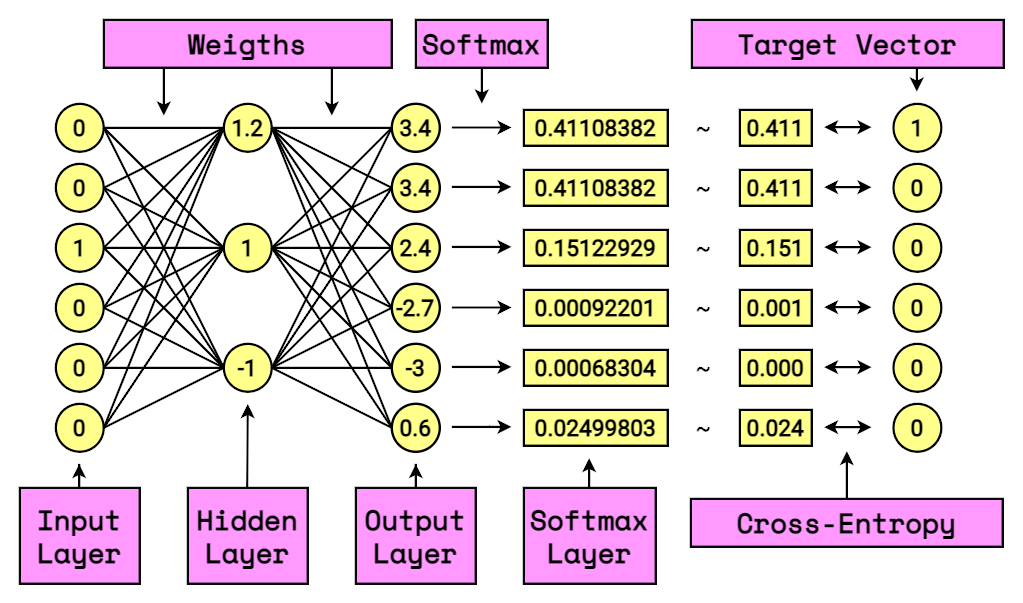

**Проблемы:**
- Огромный словарь (сотни тысяч слов);
- Могут подходить несколько вариантов.



---



#### Negative Sampling

Вместо того, чтобы каждый раз идти по всему словарю, берем несколько случайных "неверных" слов и оптимизируем лосс, используя их, как негативные примеры.

Очень важная идея, сейчас используется буквально везде (где можно). Часто в виде in-batch negatives:

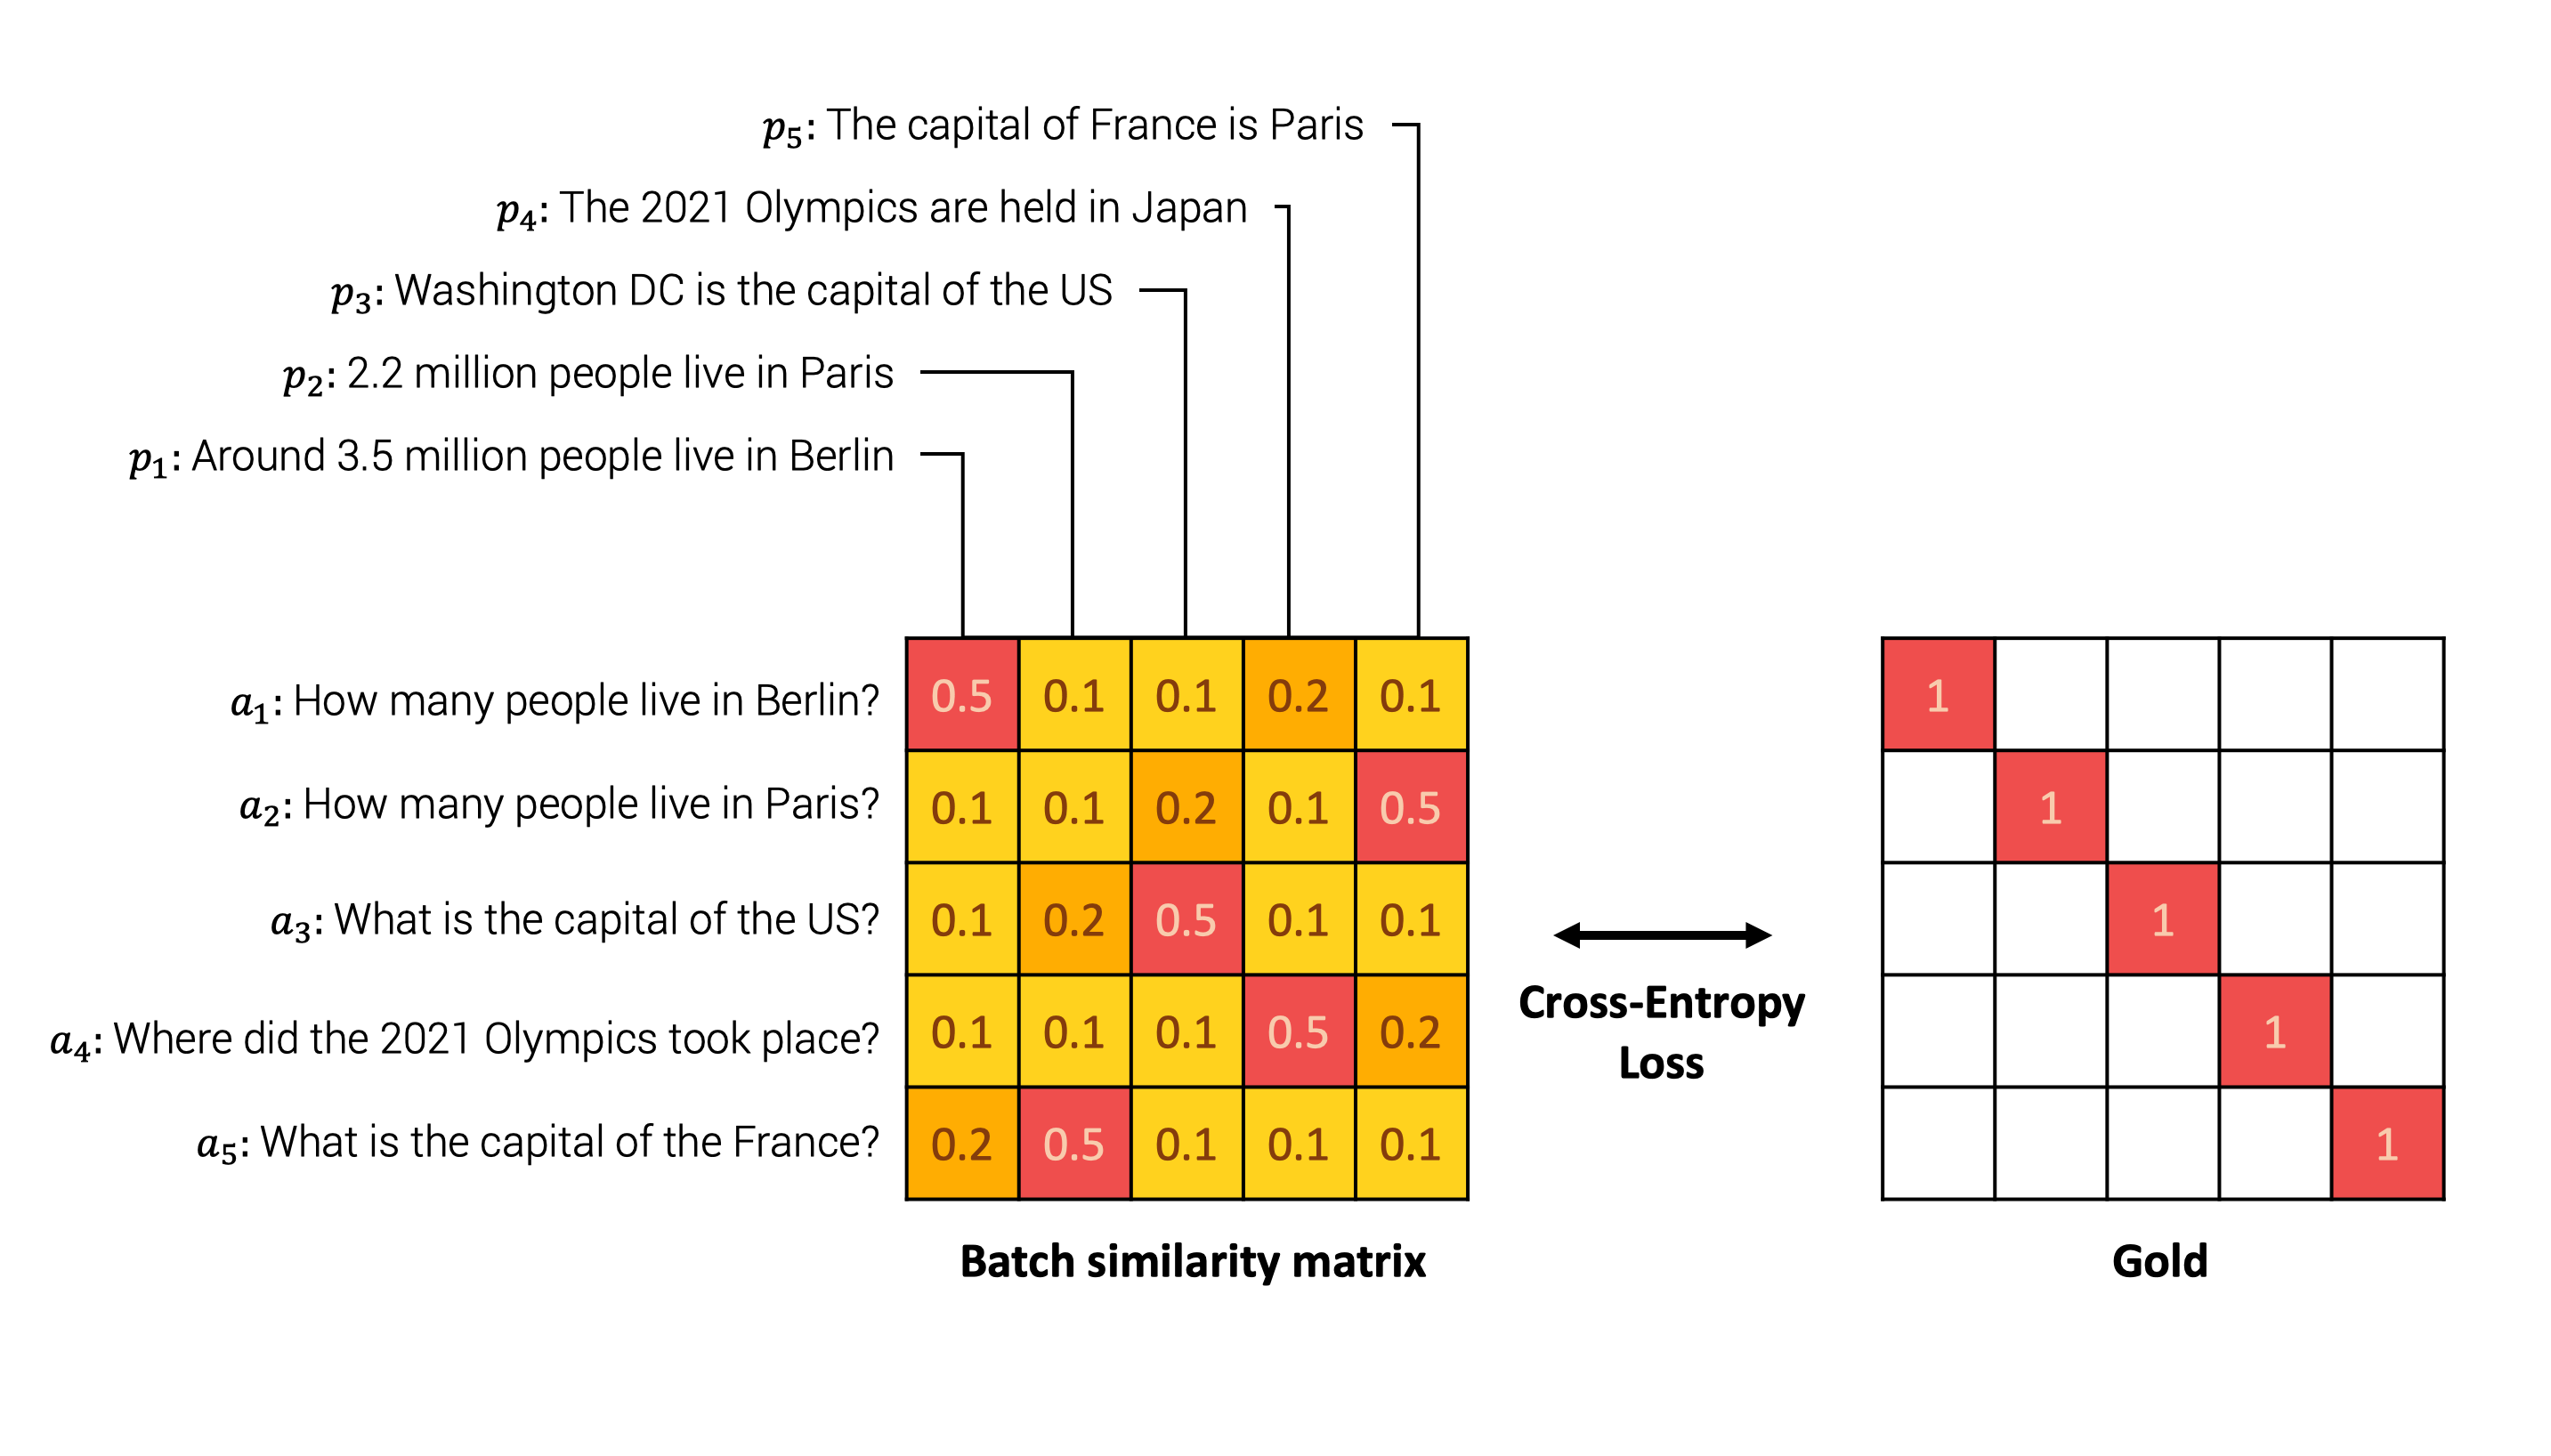

Чем больше батч, тем эффективнее обучение.



---



#### CBOW vs Skip-gram

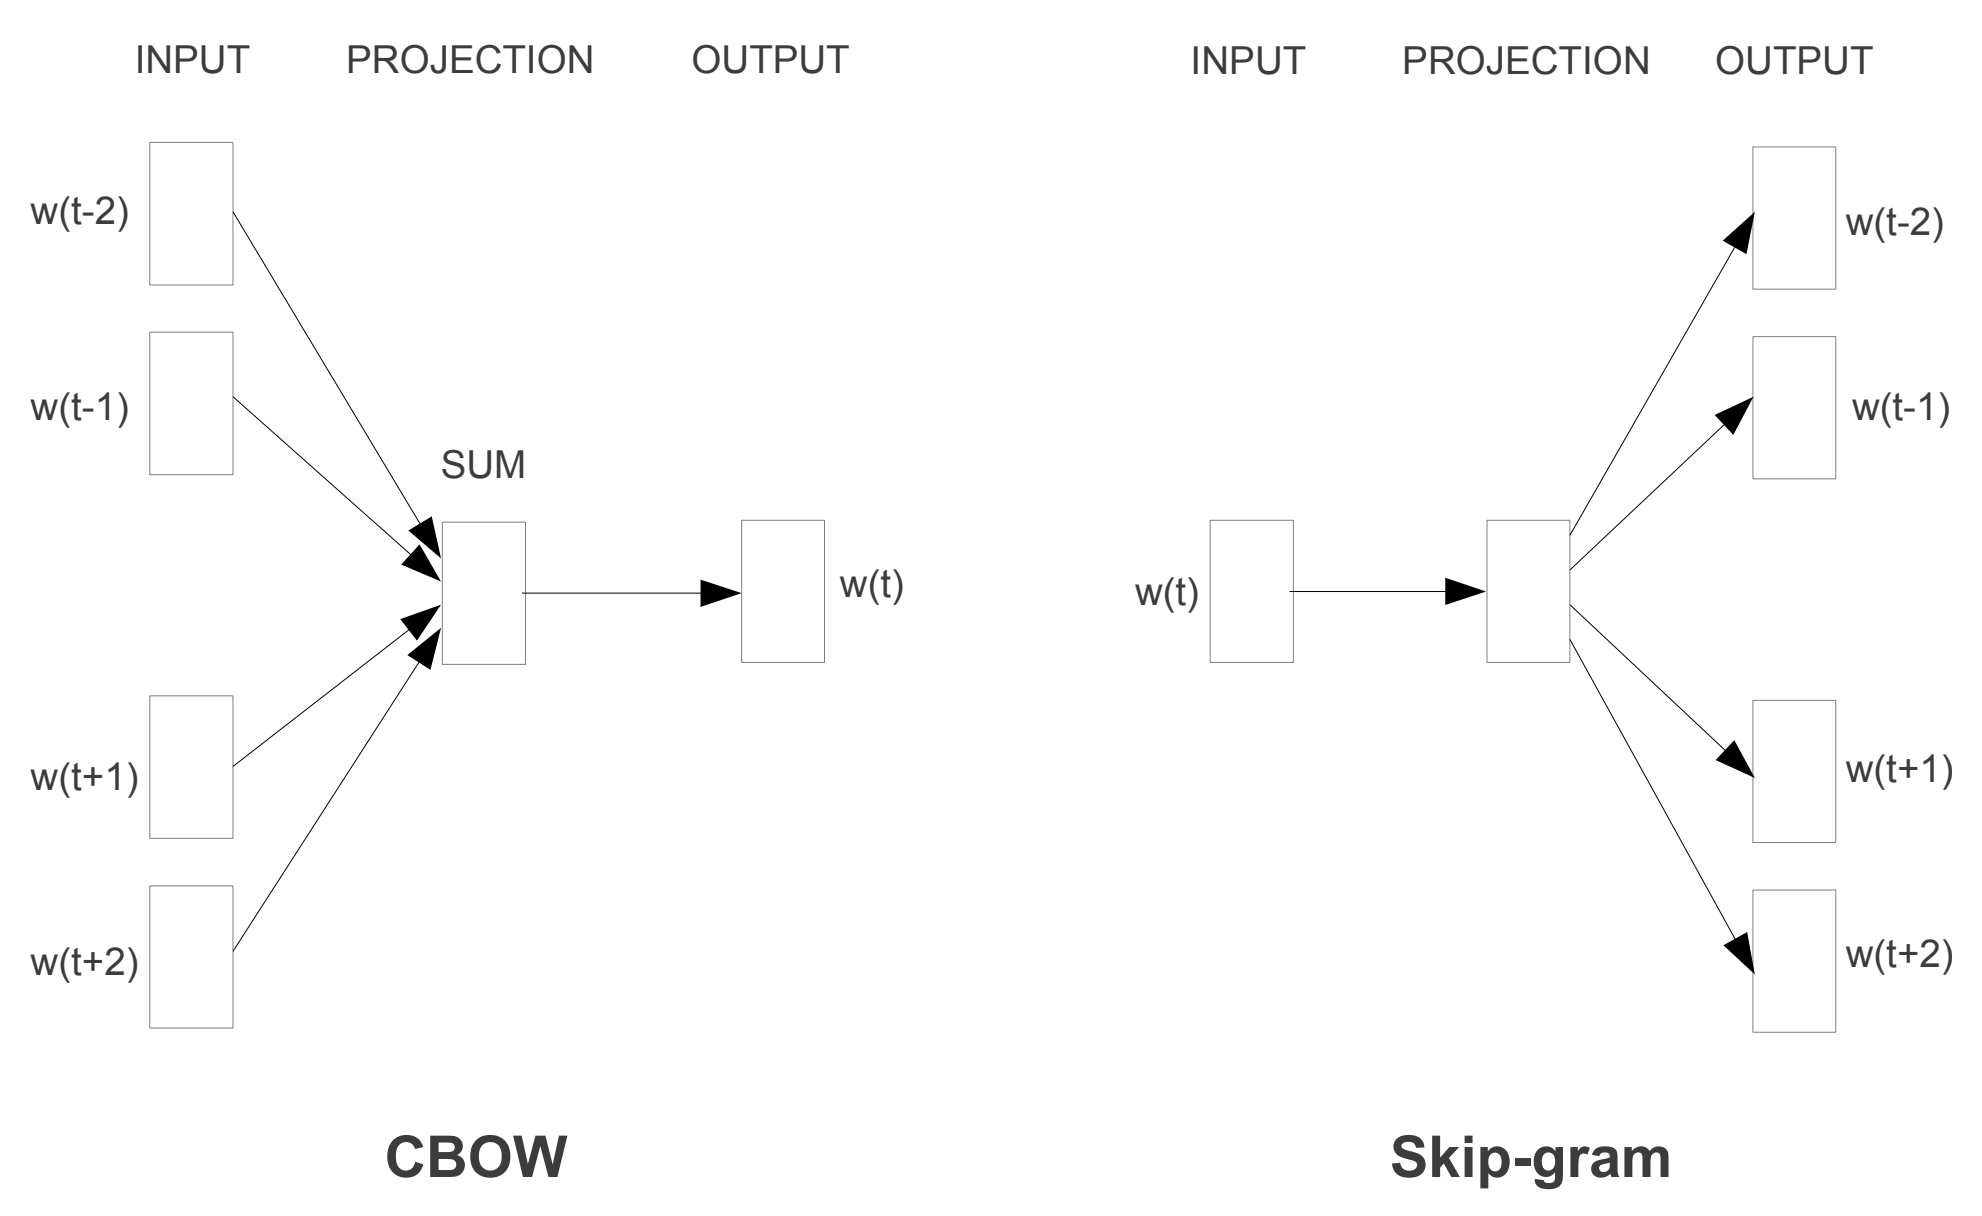

**Вопрос:** какие преимущества у каждого из методов в каких ситуациях?

##### Плюсы CBOW

- Лучше для частотных слов (почему?);
- Лучше учит синтаксические связи (кот и коты ближе друг к другу);
- Учится быстрее.

##### Плюсы Skip-gram

- Меньше переобучается на частотные слова;
- Лучше выражает редкие слова;
- Требует меньше данных.

*❔Что будем делать со словами, которых у нас нет в словаре?*

Сделаем специальный токен \<unk\> и будем учить как обычно!



---



#### Интуиция и прикольные свойства

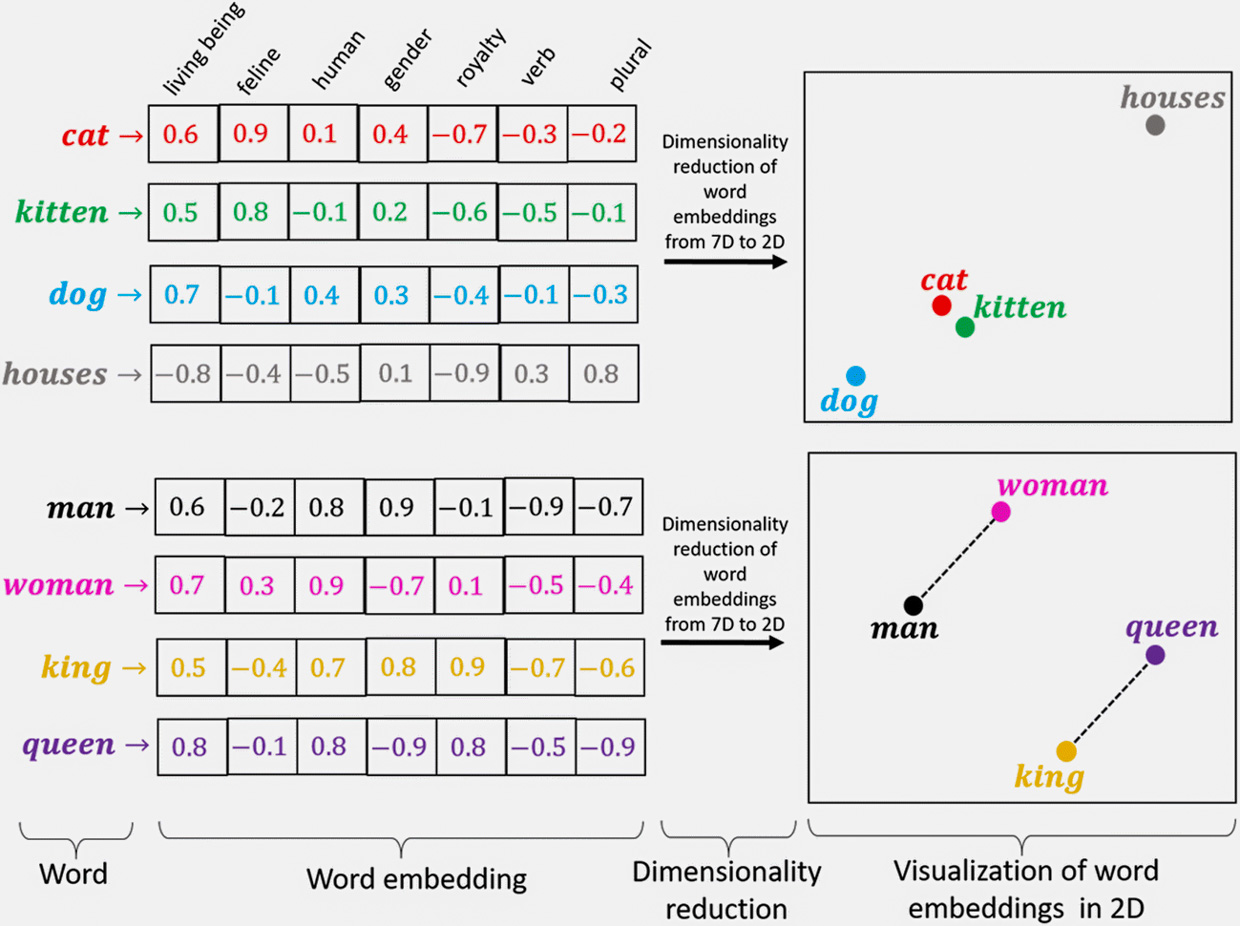

In [ ]:
from navec import Navec

navec = Navec.load('data/navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
navec["<unk>"]

In [ ]:
navec["<unk>"].shape

In [ ]:
navec_embeddings = torch.from_numpy(np.stack(list(map(navec.get, navec.vocab.words[:-2]))))
navec_embeddings = torch.nn.functional.normalize(navec_embeddings, dim=-1)

idx_to_word = dict(enumerate(navec.vocab.words[:-2]))

In [ ]:
def find_closest(word: str | torch.Tensor, top_k=5):
    if isinstance(word, str):
        embedding = torch.nn.functional.normalize(torch.from_numpy(navec[word]), dim=0)
    else:
        embedding = word

    sim = embedding @ navec_embeddings.T
    idx = sim.topk(top_k + 1).indices

    top_sim = sim[idx][1:].tolist()
    top_words = [idx_to_word[i] for i in idx.tolist()[1:]]

    return pd.DataFrame(zip(top_words, top_sim), columns=["word", "similarity"])

In [ ]:
find_closest("кот")

In [ ]:
find_closest("мелкий")

In [ ]:
def find_closest_after_math(main, sub, add):
    final_vec = torch.from_numpy(navec[main] - navec[sub] + navec[add])
    final_vec = torch.nn.functional.normalize(final_vec, dim=0)

    return find_closest(final_vec)

In [ ]:
find_closest_after_math("король", "мужчина", "женщина")

In [ ]:
find_closest_after_math("америка", "вашингтон", "москва")

**Плюсы**
- Репрезентации слов, понимающие отношения и характеристики реального мира;
- Можно брать и использовать!


**Минусы**
- Неинтерпретируемы;
- Есть проблемы с разными значениями слов;
- Есть out-of-vocabulary слова: новые слова, редкие слова, опечатки.



---



#### Козыри

А что если брать эмбеддинги последовательностей букв?

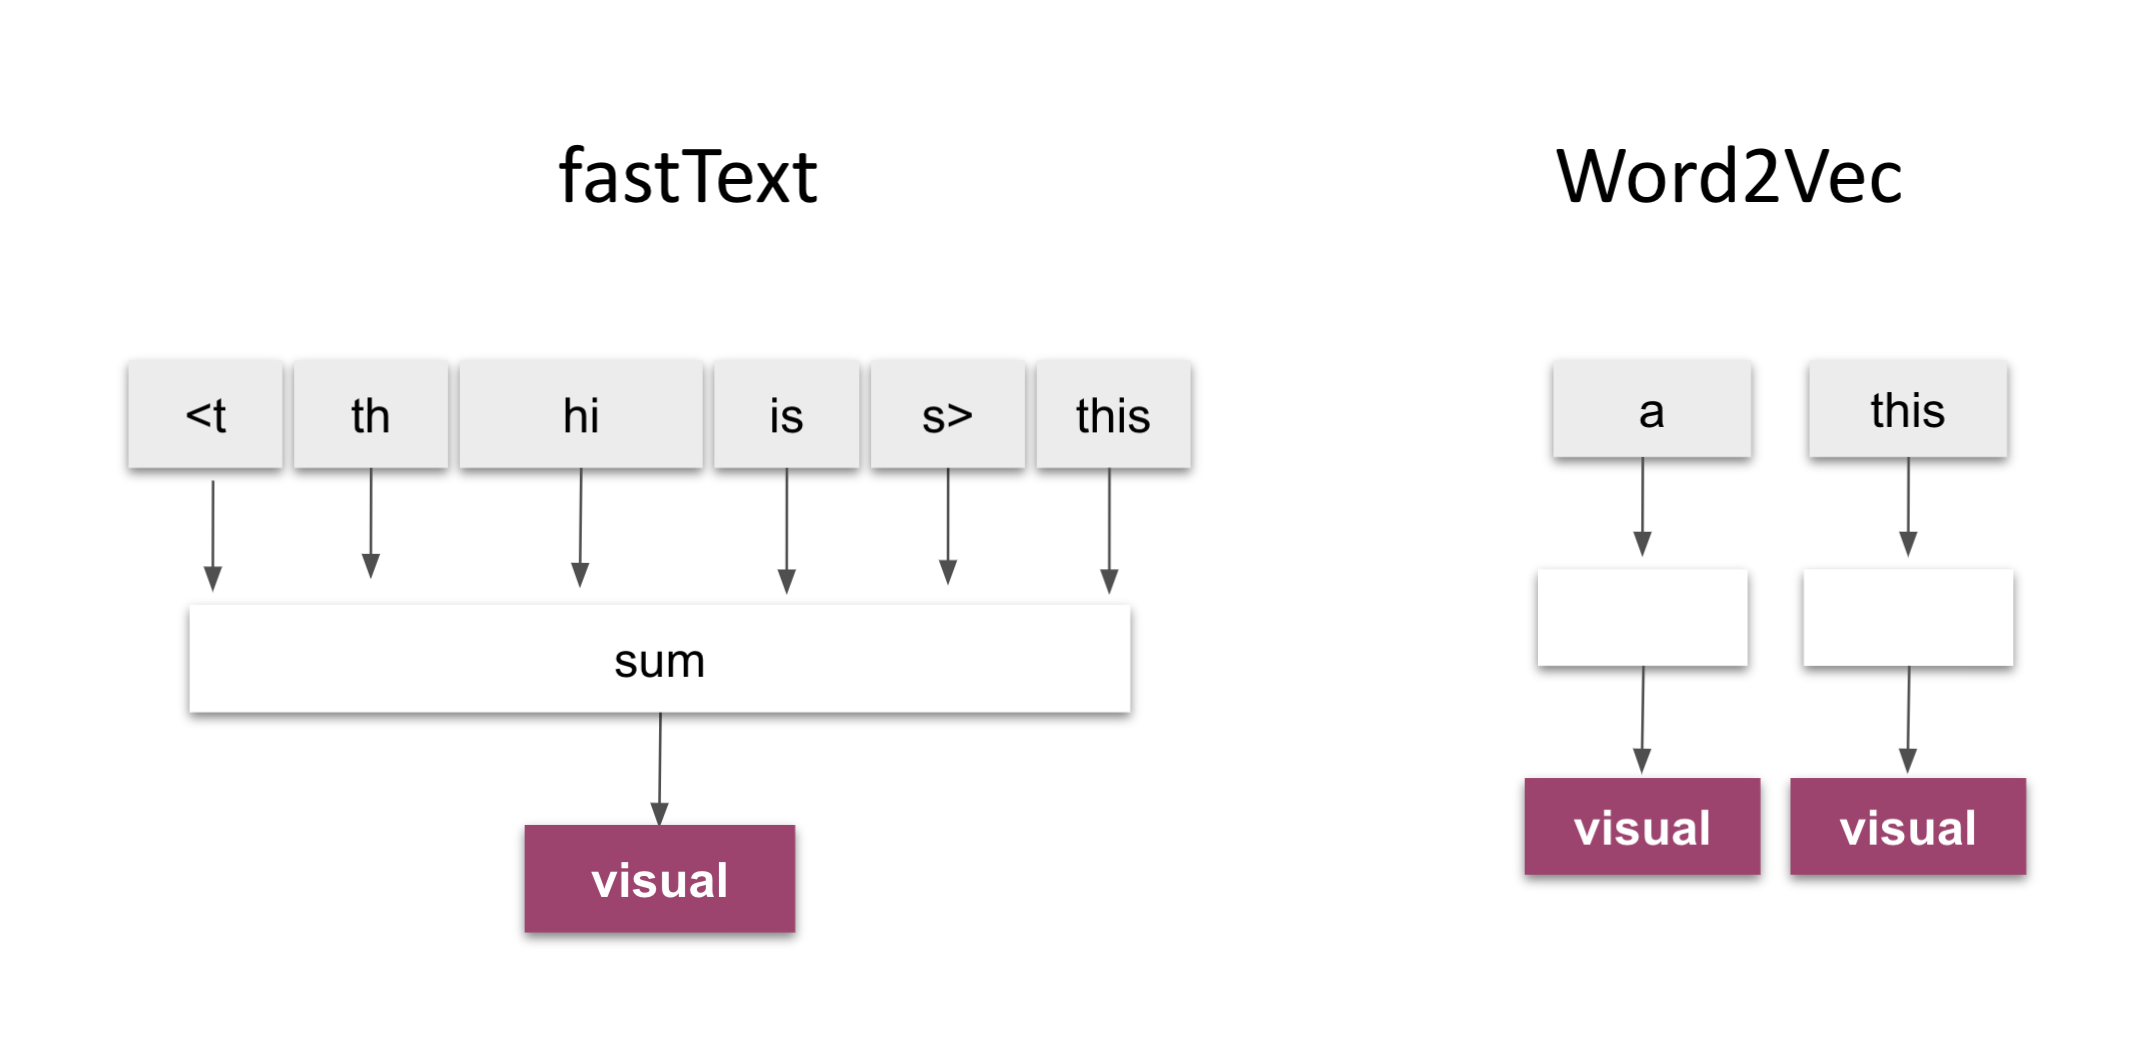

Проблема с out-of-vocabulary частично решается.

Теперь у нас есть по вектору для каждого слова.

##### ❔ Вопрос: как будем получать вектор предложения для классификации?

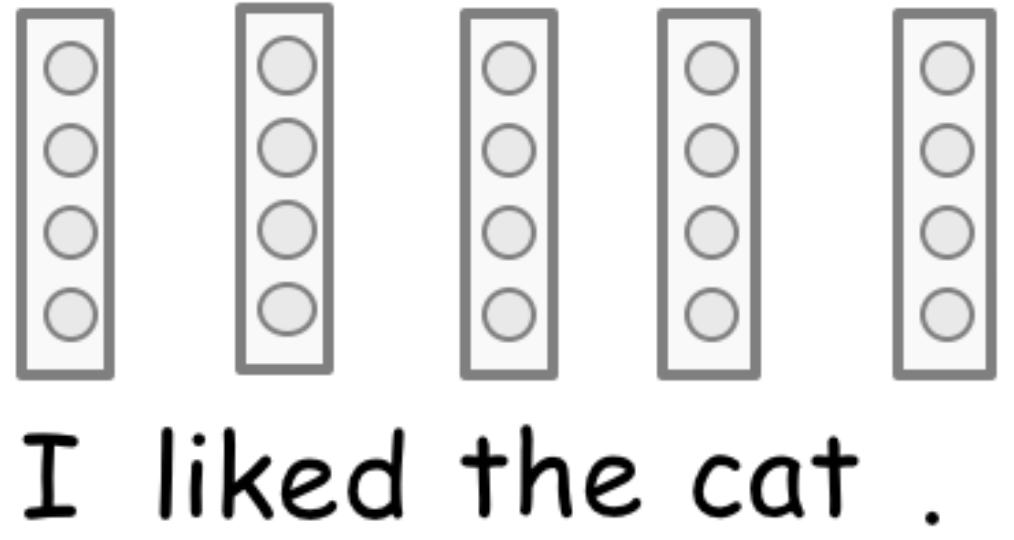

###### Ответ

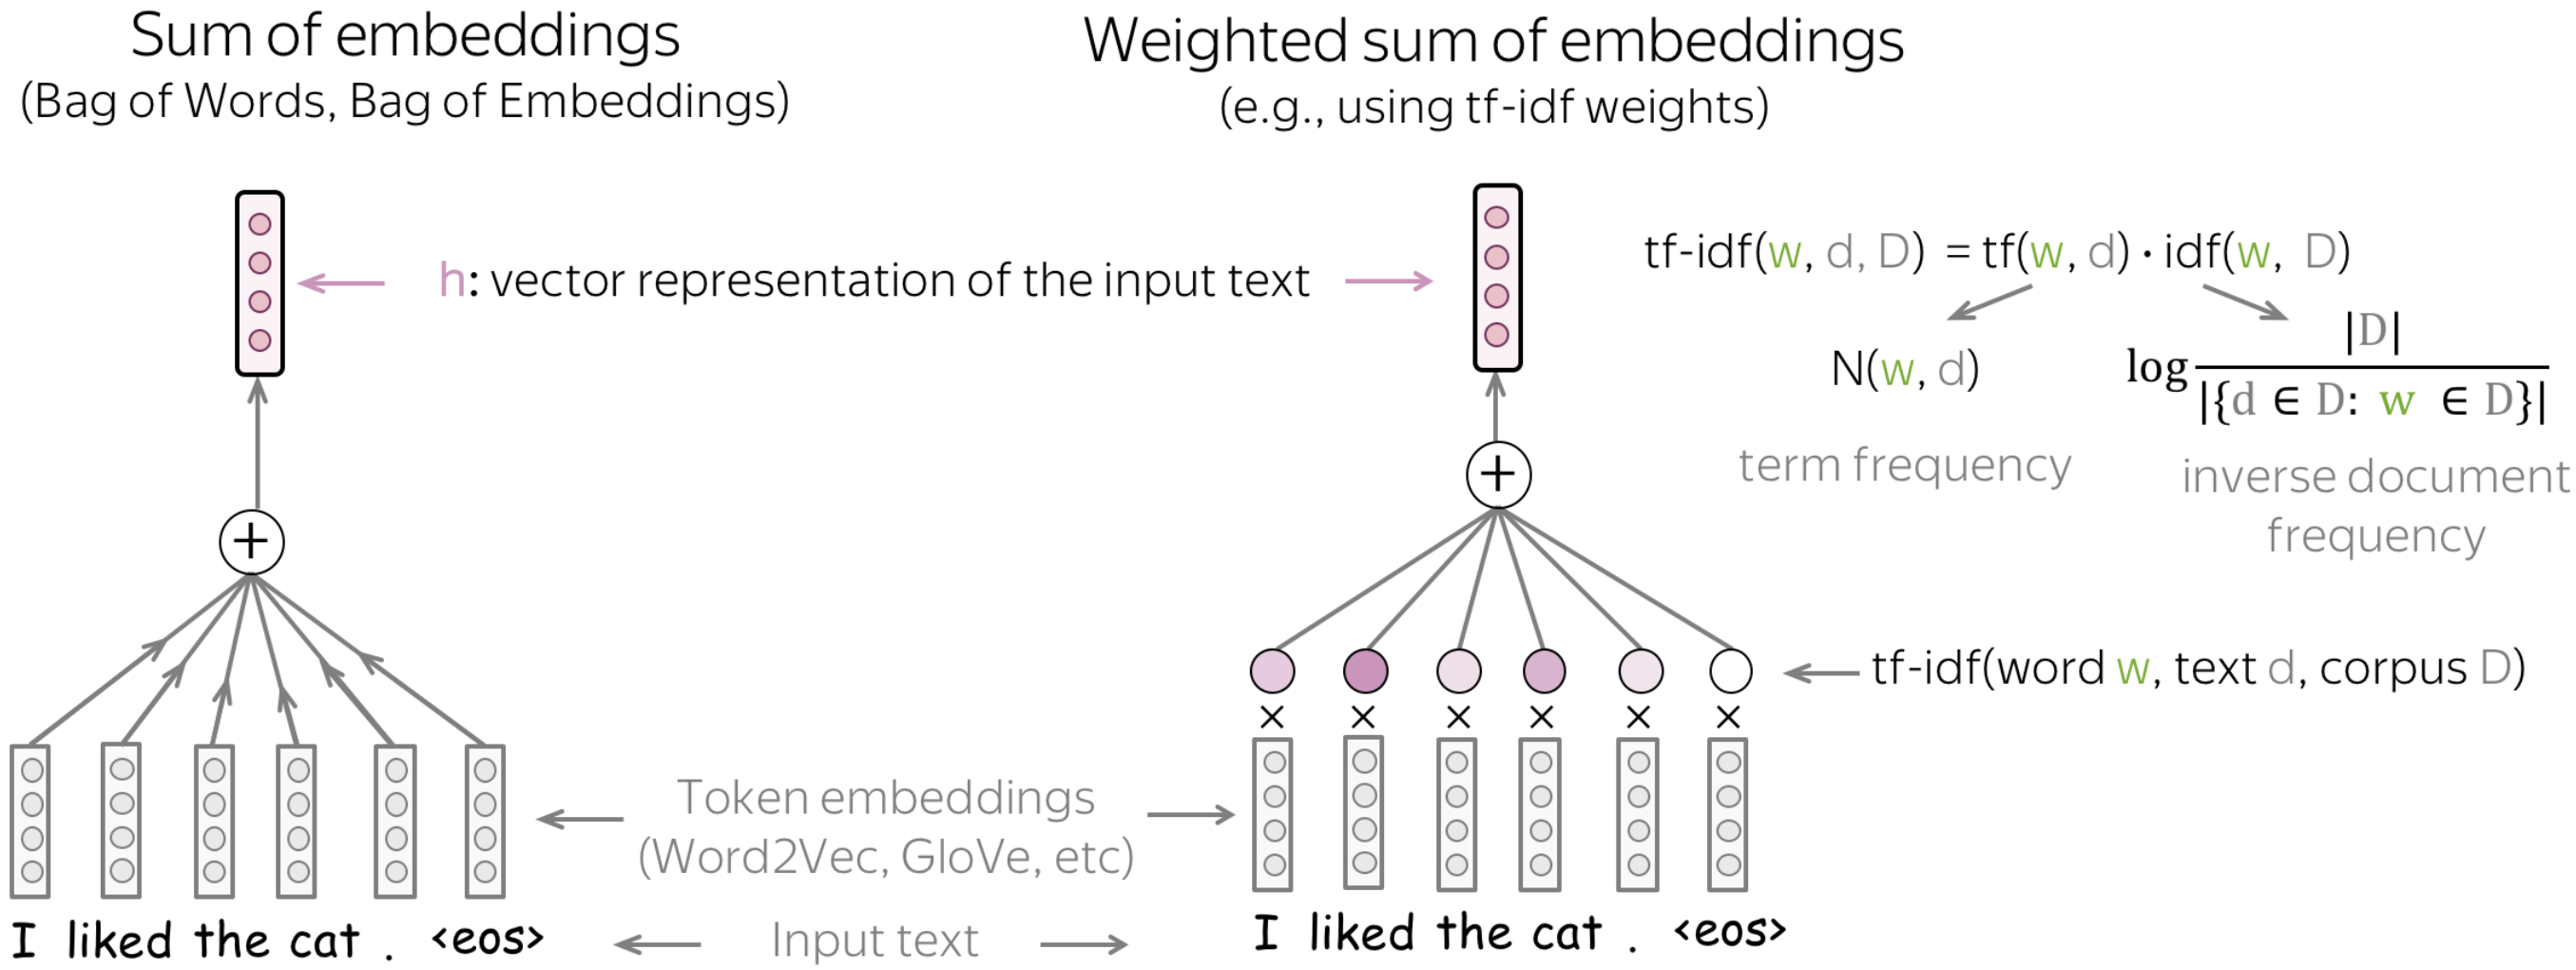



---



### Практика!

In [ ]:
def vectorize(text: list[str], mean=True) -> np.ndarray:
    embeddings = [navec.get(x, navec['<unk>']) for x in text]

    if mean:
        return np.stack(embeddings).mean(axis=0)
    else:
        return np.stack(embeddings)

In [ ]:
X_train = np.stack(train_data["processed_text"].apply(vectorize))
X_test = np.stack(test_data["processed_text"].apply(vectorize))

In [ ]:
X_train.shape

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression(max_iter=300)

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
pred_train = logreg.predict(X_train)
pred_test = logreg.predict(X_test)

In [ ]:
compute_metrics(y_train, pred_train);

In [ ]:
compute_metrics(y_test, pred_test);

Слабовато, правда? Почему?



---



### RNNs: Recurrent Neural Networks

Учитывает связь между словами, анализируя текст слово за словом и сохраняя "состояние".

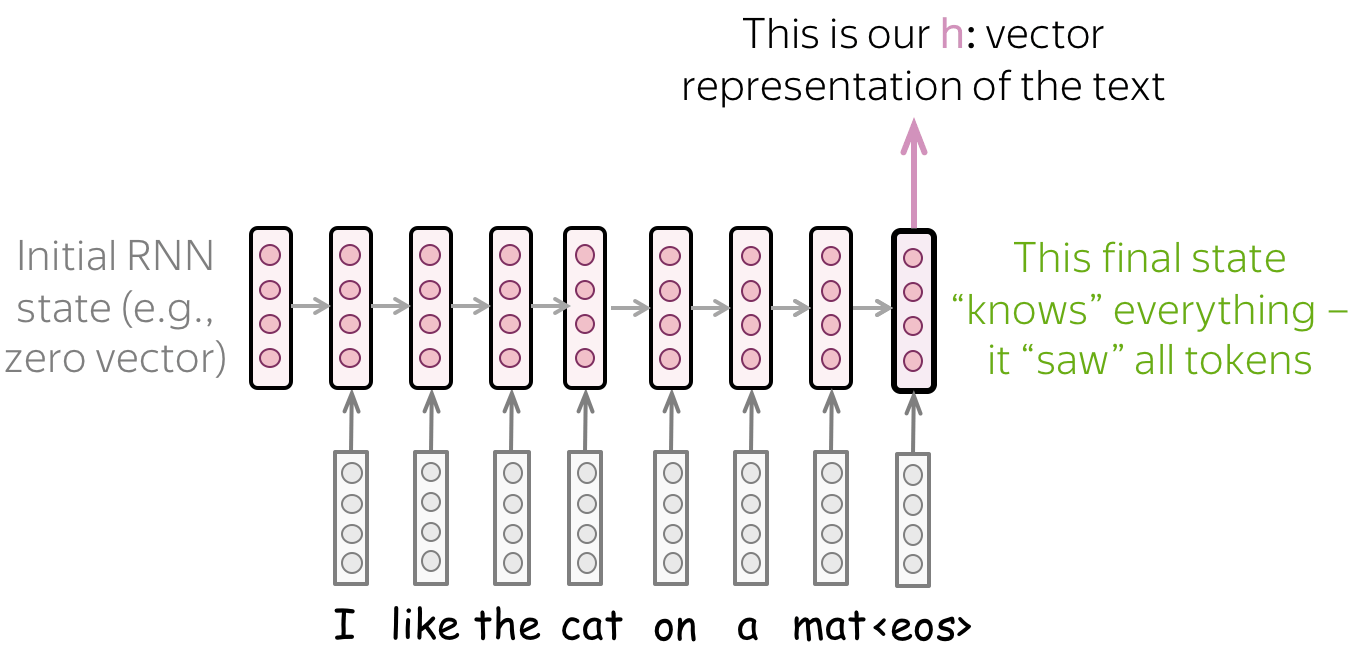



---



### Многослойные RNN

А можно много слоев?

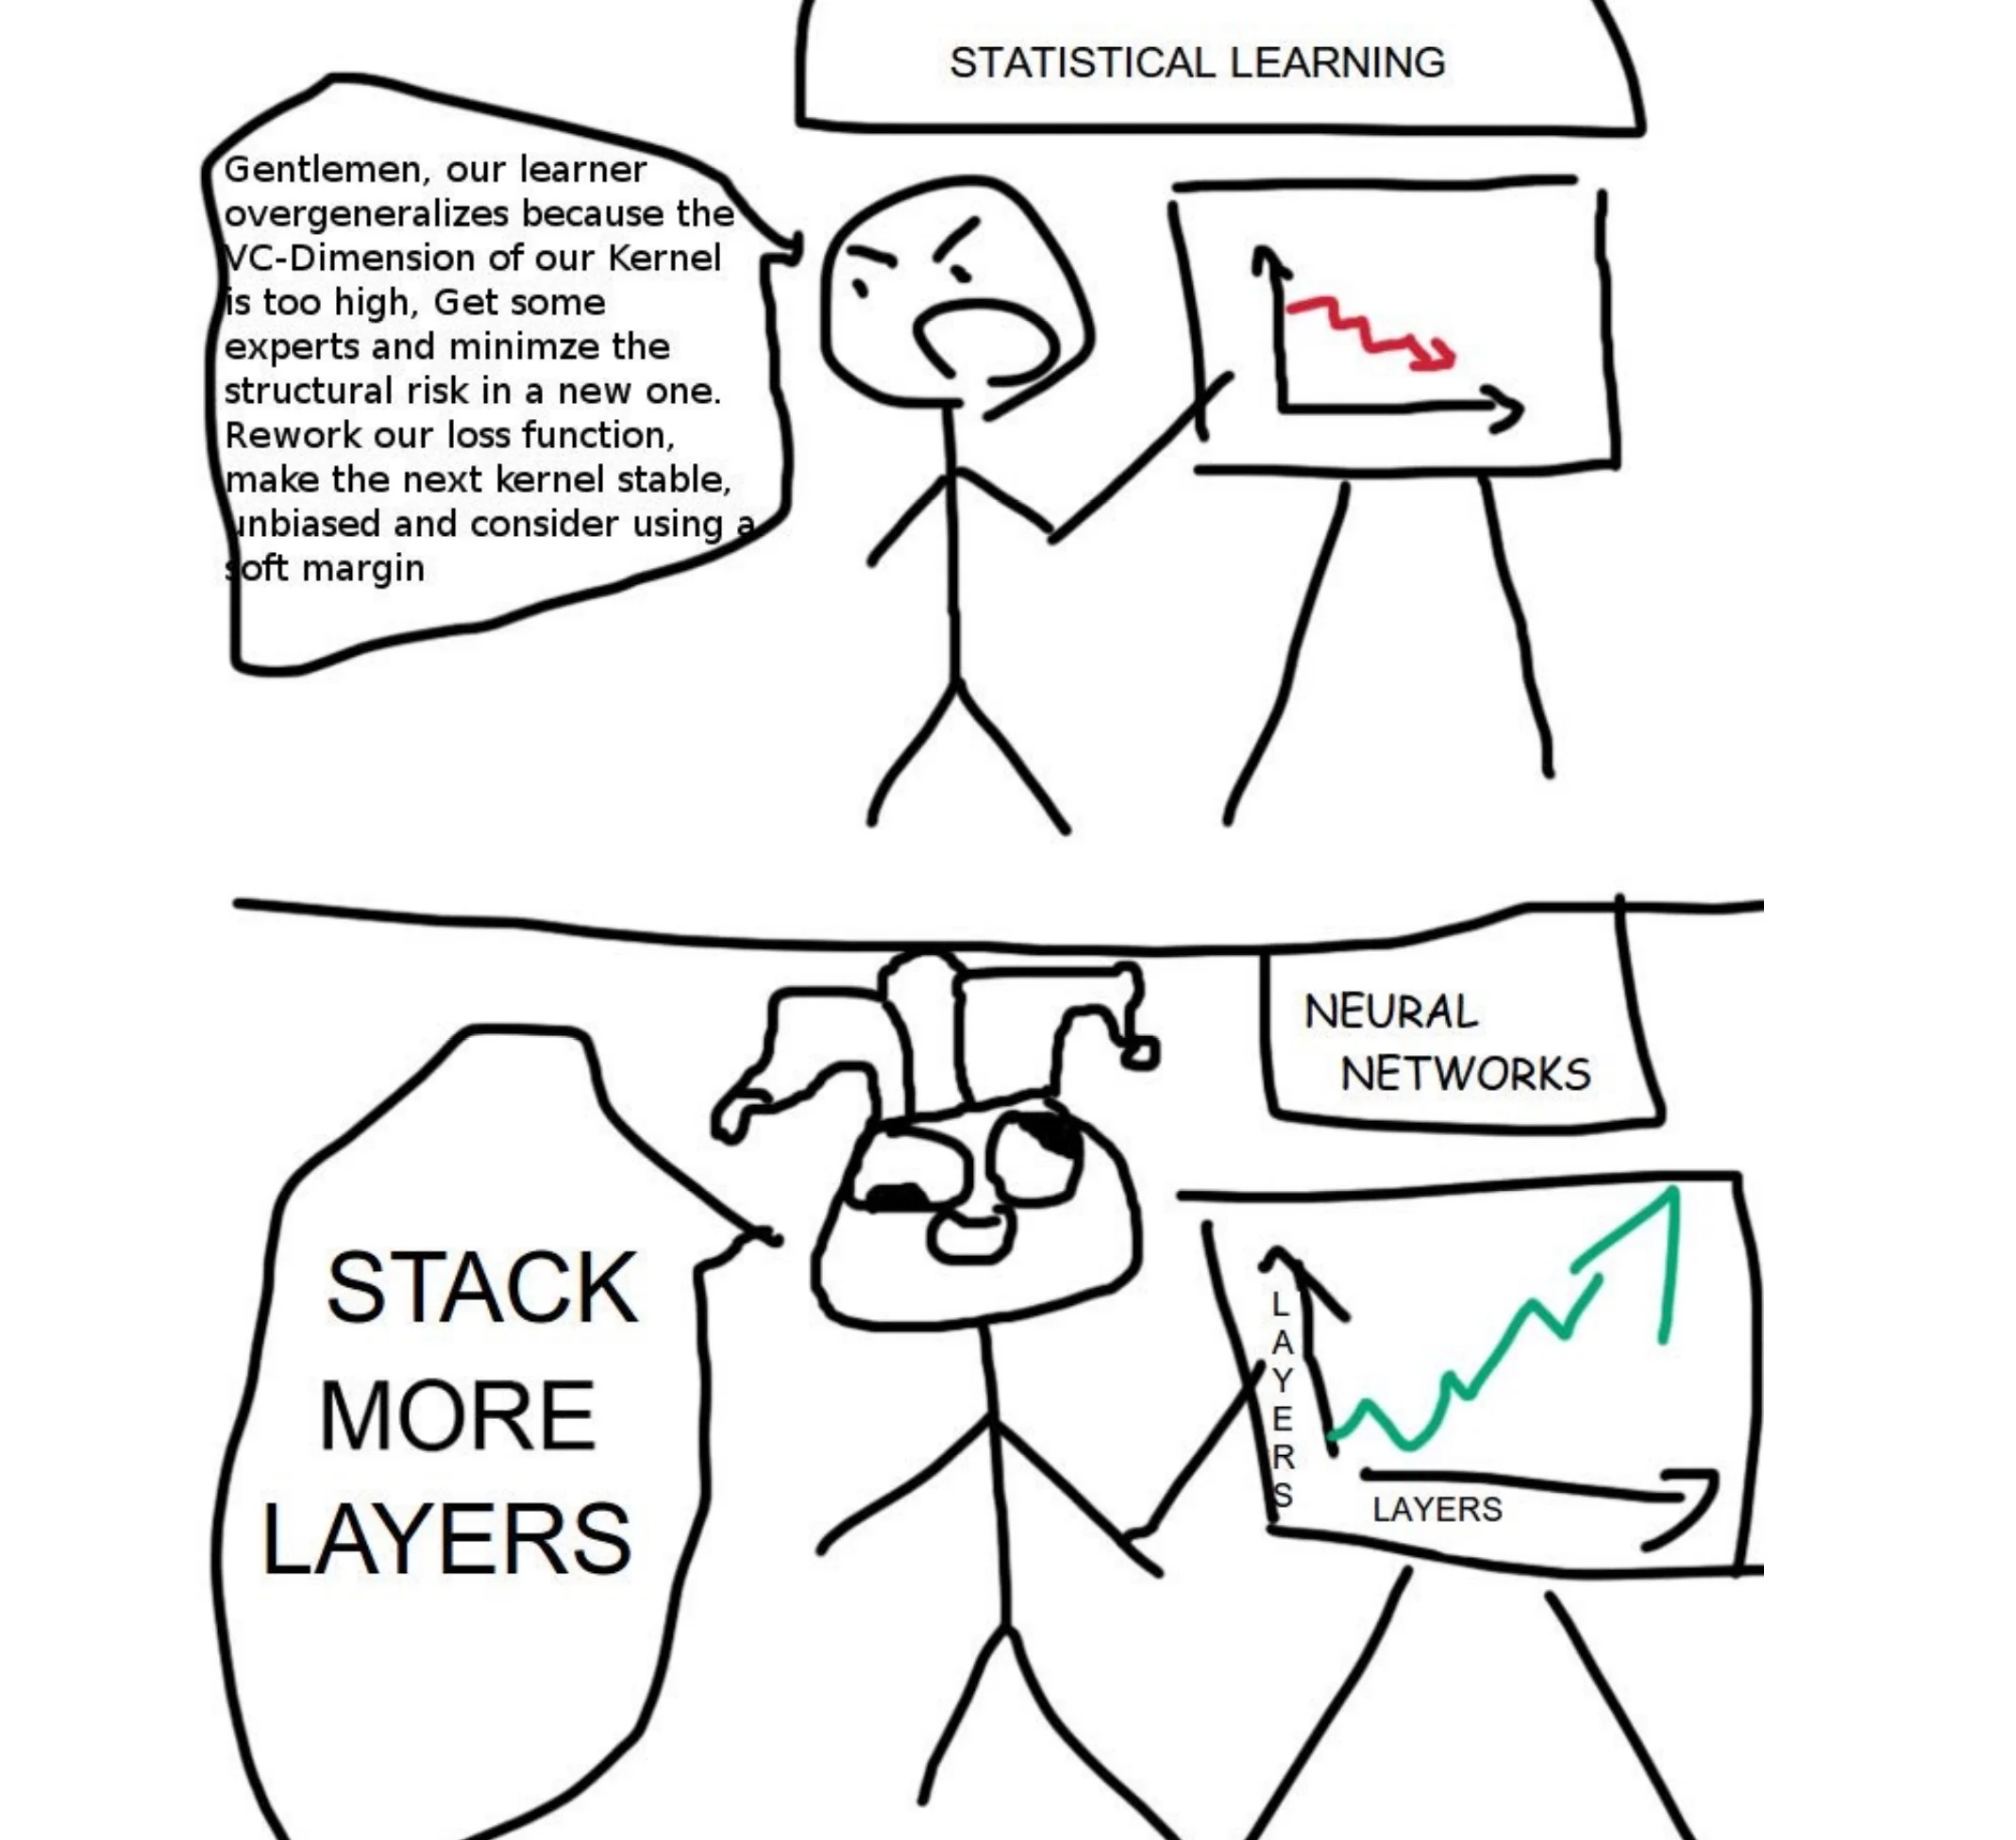

Можно!

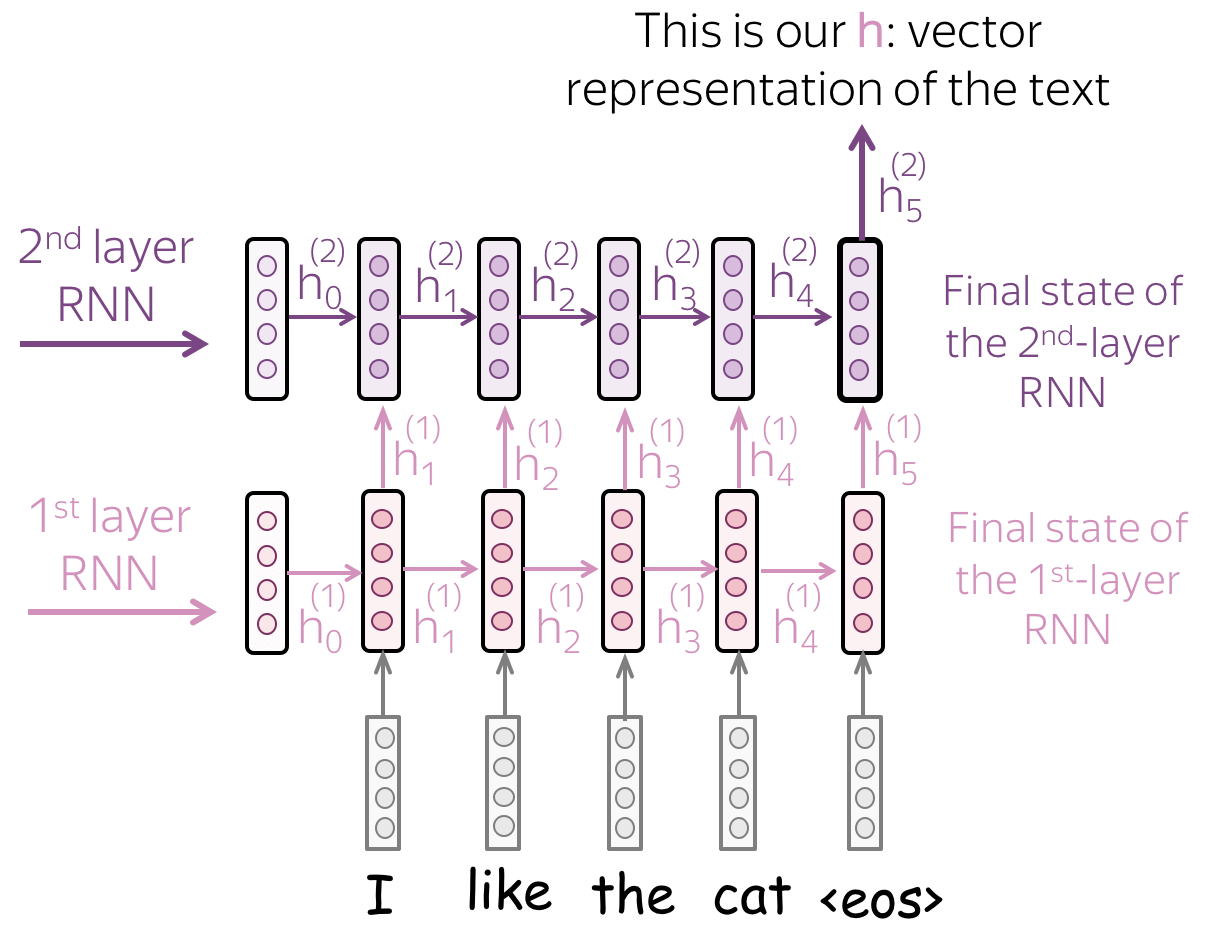

*А что, если хочется посмотреть на контекст справа?*



---



### Bidirectional RNN

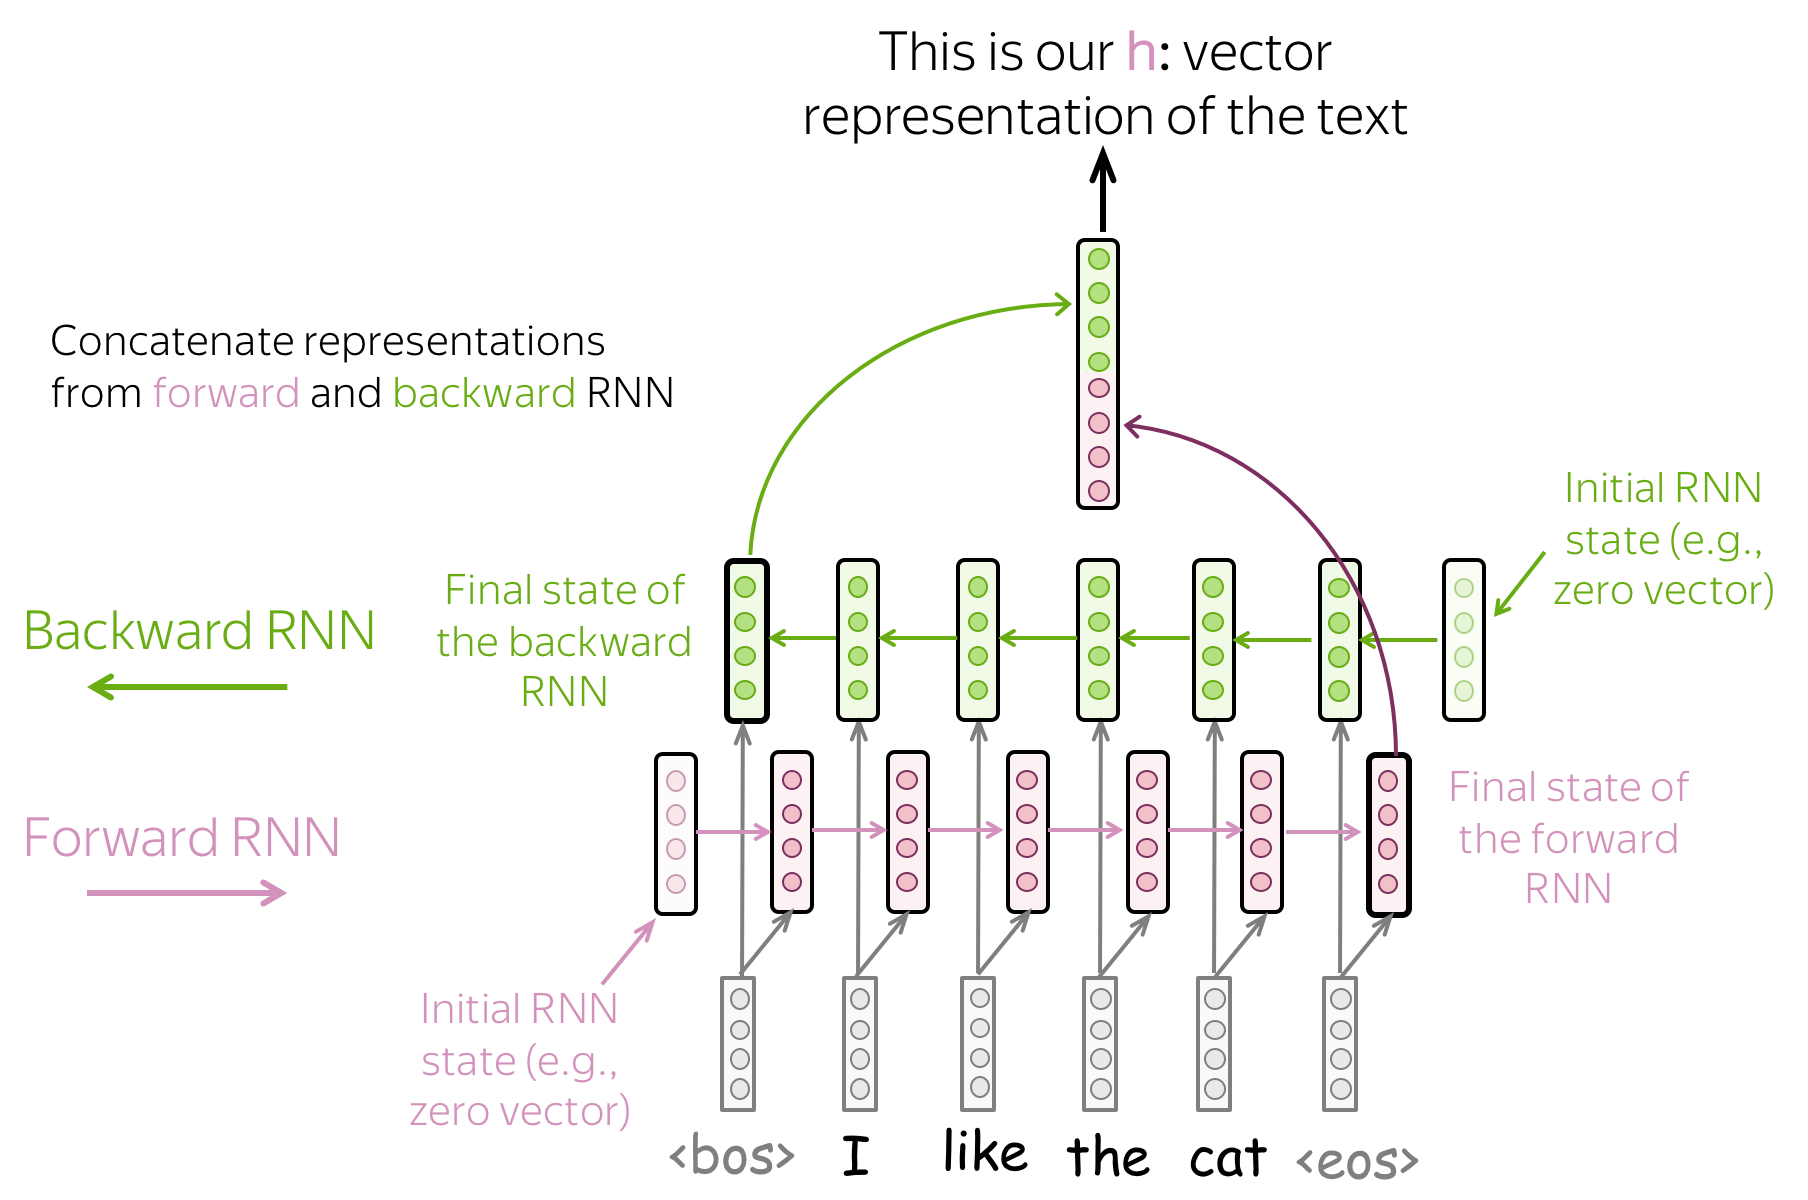



---



### Vanilla RNN

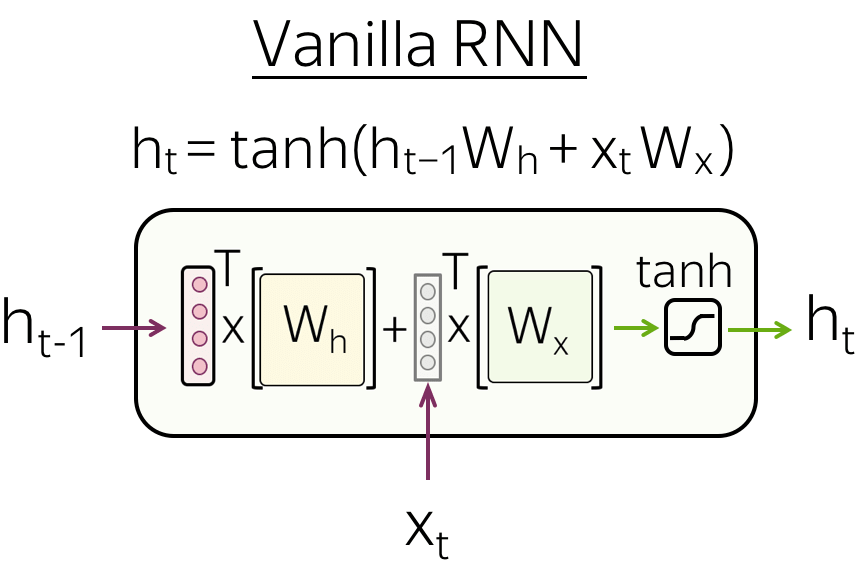

**Есть проблемки:**
- Взрывающиеся и затухающие градиенты
- Забывание длинных зависимостей



---



### LSTM: Long Short-Term Memory

На помощь приходит LSTM, которая решает эти проблемы с помощью специальных "ворот", которые реализованы в виде активационных функций (c обучаемыми весами!).

Также у LSTM есть Cell State - "память", в которую мы складываем то, что хотим запомнить надолго.

- **Cell State** - Long-Term Memory;
- **Hidden State** - Short-Term Memory.

**Какие есть ворота?**

- Forget Gate
  - Что уже не важно, что можем забыть?
  - Применяем сигмоиду - значения между 0 и 1
  - Забываем из Cell State
- Input Gate
  - Что запоминаем из новой информации?
  - Применяем сигмоиду - значения между 0 и 1
  - Дополнительно применяем тангенс - чтобы добавить нелинейности и шкалировать
  - Добавляем к Cell State
- Output Gate
  - Что хотим передать дальше?
  - Применяем сигмоиду - значения между 0 и 1
  - Домножаем на нелинейный и отшкалированный Cell State
  - Результат отдаем как выход и как скрытый слой

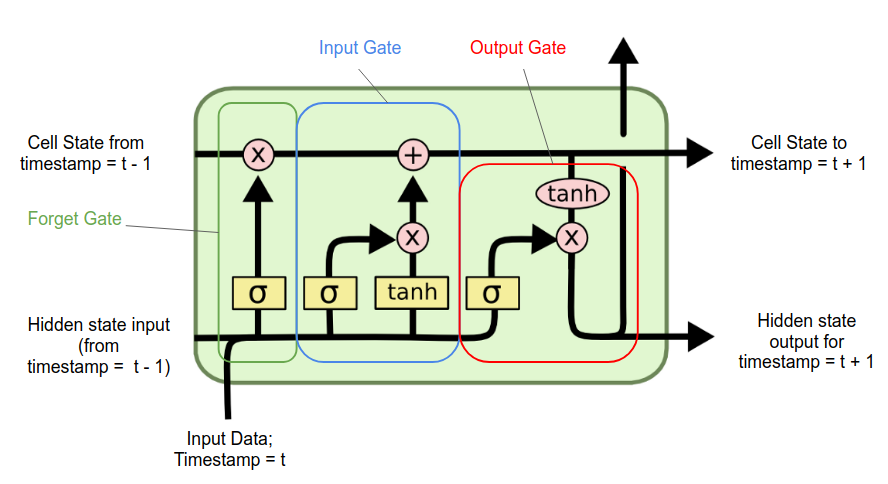

Есть ещё GRU -- она как LSTM, только попроще :)



---



### Практика!

#### Подготовим данные

Отсортируем данные по количеству слов - чтобы паддинга было как можно меньше.

Используем паддинг для выравнивания длины последовательностей - чтобы обрабатывать в одном батче.

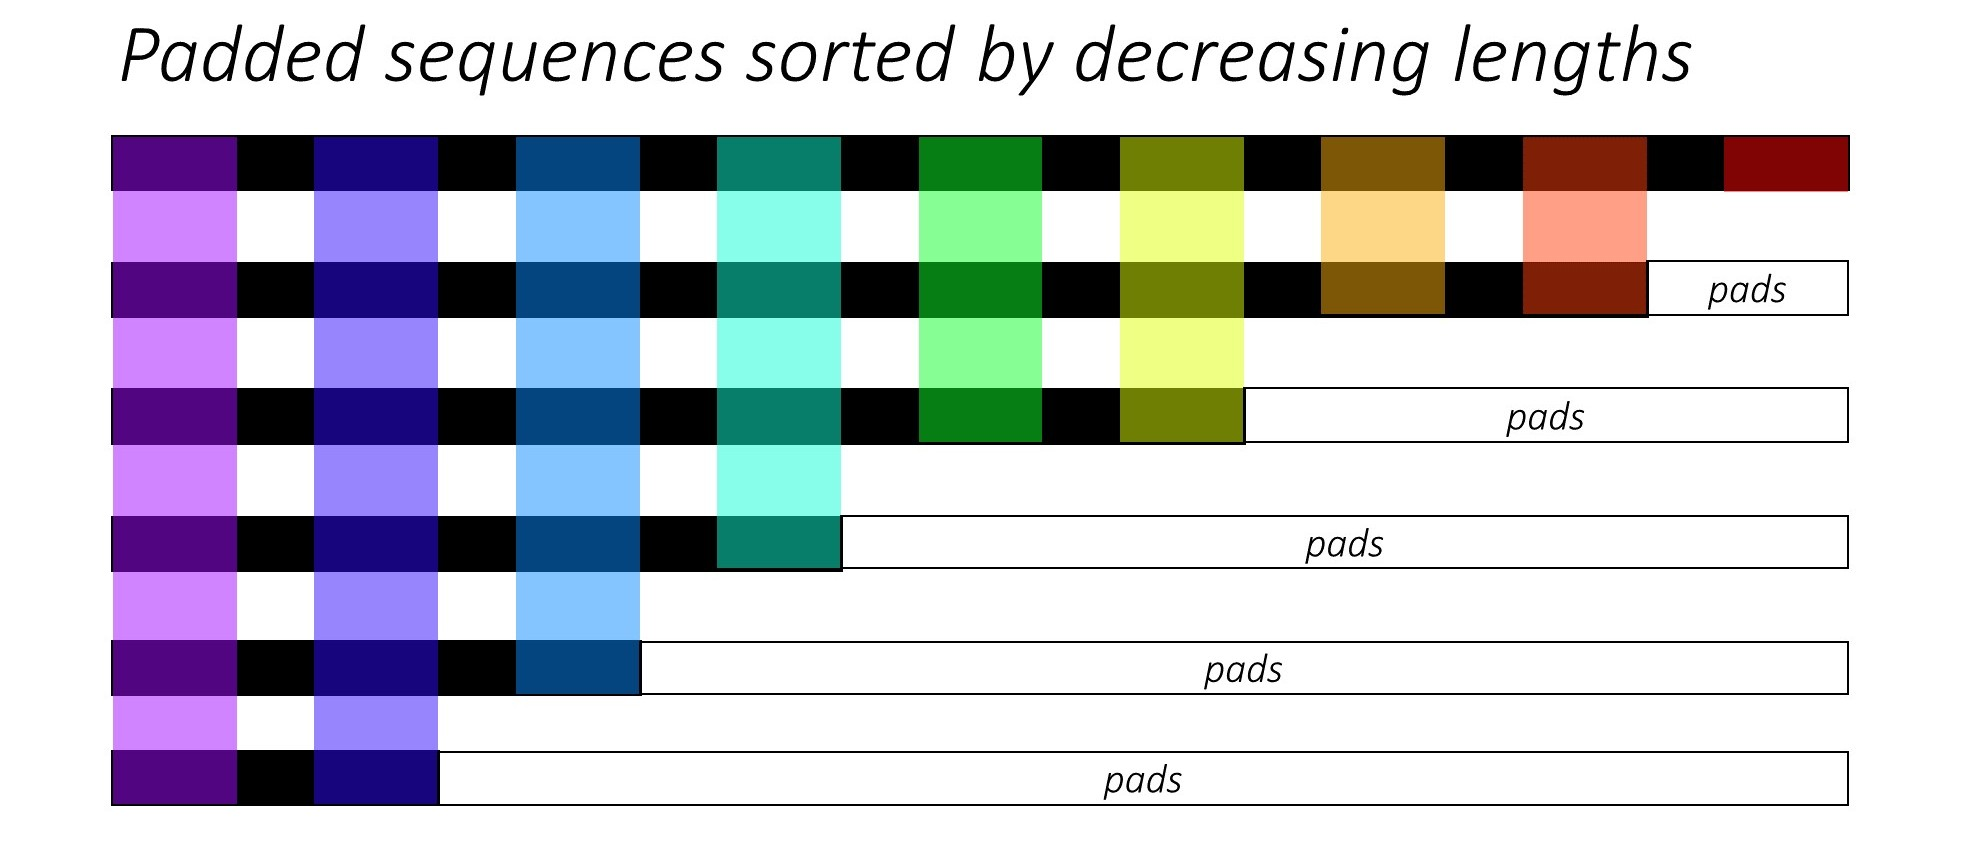

In [ ]:
sorted_idx = train_data["processed_text"].str.len().sort_values().index

In [ ]:
train_data = train_data.loc[sorted_idx]
y_train = train_data["target"].values

In [ ]:
X_train = train_data["processed_text"].values
X_test = test_data["processed_text"].values



---



#### Посчитаем слова

In [ ]:
from collections import Counter
from functools import partial, reduce

In [ ]:
counts = Counter(reduce(lambda x, y: x + y, X_train))
counts.most_common(9)

In [ ]:
len(counts.keys())

In [ ]:
word_dist = pd.Series(counts).sort_values(ascending=False)

В целом, распределение похоже на распределение Ципфа:

In [ ]:
word_dist.head(150).plot.area(figsize=(20, 5))

In [ ]:
cumsums = (word_dist / counts.total()).cumsum().reset_index(name="cumsum")

In [ ]:
len(cumsums.query("cumsum <= 0.50"))

In [ ]:
vocab_size = len(cumsums.query("cumsum <= 0.9"))
print(vocab_size)

In [ ]:
vocab = ["<UNK>"] + cumsums["index"].iloc[0:vocab_size].tolist()

In [ ]:
word2idx = dict(zip(vocab, range(len(vocab))))

In [ ]:
word2idx



---



#### Напишем модель

Хотим сделать [Bidirectional-RNN](https://colab.research.google.com/drive/1WOS4gxEm9tQsVFV8S5e05yPoeA8yOYMZ#scrollTo=uKxUvnEIQKez&line=1&uniqifier=1) для классификации сообщений на нормальные и токсичные

**Есть два варианта получения исходных эмбеддингов:**
- Просто взять word2vec;
- Инициализировать (с нуля или из word2vec) и обучить самим!

In [ ]:
BATCH_SIZE = 512
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 300
NUM_CLASSES = 4
NUM_EPOCHS = 5
NUM_LAYERS = 3
LEARNING_RATE = 5e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from torch import nn

In [ ]:
class BiLstmForClassification(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes) -> None:
        super().__init__()

        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True
        )
        self.ff = nn.Linear(hidden_size * 2, num_classes)

        self.embedding = None
        self._word2idx = None
        self._embed = None

    def forward(self, texts):
        if self._embed is None:
            raise NotImplementedError("You forgot to init embeddings.")

        embeddings = self._embed(texts)
        embeddings = self._prepare_embeddings(embeddings)

        out, (hidden, cell) = self.lstm(embeddings)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)

        return self.ff(hidden)

    def init_embeddings(self, learn_embeddings, **kwargs):
        """
        Инитим эмбеддинги в зависимости от параметра: либо берем предобученные, либо делаем свою матрицу эмбеддингов.
        """
        if learn_embeddings:
            self._word2idx = kwargs["word2idx"]

            embedding_matrix = self._init_embedding_matrix()
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
            self._embed = self._embed_self
        else:
            self._embed = self._embed_navec

    def _init_embedding_matrix(self):
        """
        Инициализируем матрицу эмбеддингов.

        Если слово есть в navec - берем его для инициализации; если нет - заполняем рандомно.
        """
        vocab_size = len(self._word2idx)
        init_matrix = np.random.rand(vocab_size, self.emb_size)

        for word, idx in self._word2idx.items():
            navec_emb = navec.get(word)
            if navec_emb is not None:
                init_matrix[idx] = navec_emb

        return torch.from_numpy(init_matrix).to(torch.float32)

    def _embed_self(self, texts: list[list[str]]) -> list[torch.Tensor]:
        """ Вызываем слой эмбеддингов на IDшники слов """
        ids = list(map(self._convert_words2idx, texts))
        embeddings = list(map(self.embedding, ids))

        return embeddings

    def _convert_words2idx(self, text: list[str]) -> list[int]:
        """ Конвертируем слова в IDшники """
        encoded = [self._word2idx.get(w, self._word2idx["<UNK>"]) for w in text]

        return torch.tensor(encoded, dtype=torch.int).to(DEVICE)

    @staticmethod
    def _embed_navec(texts: list[list[str]]) -> list[torch.Tensor]:
        """ Просто получаем вектора из navec, как уже делали раньше. """
        embeddings = list(map(partial(vectorize, mean=False), texts))
        embeddings = list(map(torch.from_numpy, embeddings))

        return embeddings

    @staticmethod
    def _prepare_embeddings(embeddings: list[torch.Tensor]):
        lengths = list(map(len, embeddings))

        embeddings = nn.utils.rnn.pad_sequence(embeddings, batch_first=True)
        embeddings = nn.utils.rnn.pack_padded_sequence(
            embeddings, lengths, batch_first=True, enforce_sorted=False
        )

        return embeddings.to(DEVICE)



---



#### Слой эмбеддинга

In [ ]:
?nn.Embedding

In [ ]:
emb_layer = nn.Embedding(10, 8)
emb_layer

In [ ]:
emb_parameters = list(emb_layer.parameters())[0]
emb_parameters

In [ ]:
emb_parameters.size()

Оказывается, это просто линейный слой без bias'а!



---



#### ❔ Вопрос: как можем получить эмбеддинг пятого слова?

1. Просто получить по индексу

In [ ]:
emb_parameters[5]

2. Сделать one-hot vector и прокинуть через линейный слой

In [ ]:
onehot_vector = nn.functional.one_hot(torch.tensor(5), 10).to(torch.float)
onehot_vector

In [ ]:
onehot_vector @ emb_parameters

Может быть нужно, если через операцию получения по индексу не текут градиенты (как в некоторых фреймворках)



---



#### Датасеты и даталоадеры

In [ ]:
from torch.utils.data import Dataset, DataLoader
from operator import itemgetter

In [ ]:
class LstmDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
def collate(batch):
    texts = list(map(itemgetter(0), batch))
    labels = list(map(itemgetter(1), batch))

    labels = torch.tensor(labels)

    return texts, labels

In [ ]:
train_dataset = LstmDataset(X_train, y_train)
test_dataset = LstmDataset(X_test, y_test)

NameError: name 'X_train' is not defined

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)



---



#### Модель с эмбеддингами word2vec

In [ ]:
lstm = BiLstmForClassification(EMBEDDING_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES)
lstm.init_embeddings(learn_embeddings=False, word2idx=word2idx)
lstm.to(DEVICE)

In [ ]:
import torch.optim as optim

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=LEARNING_RATE)

In [ ]:
def train_epoch():
    lstm.train()

    losses = []
    for texts, labels in tqdm(train_dataloader, total=len(train_dataloader)):
        labels = labels.to(DEVICE)

        outputs = lstm(texts)

        loss = loss_func(outputs, labels)

        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        optimizer.zero_grad()

    epoch_loss = sum(losses) / len(losses)

    return epoch_loss

In [ ]:
@torch.no_grad()
def test_epoch():
    lstm.eval()

    losses = []
    predictions = []
    for texts, labels in tqdm(test_dataloader, total=len(test_dataloader)):
        labels = labels.to(DEVICE)

        outputs = lstm(texts)

        loss = loss_func(outputs, labels)
        pred_labels = outputs.argmax(dim=1).tolist()

        predictions.extend(pred_labels)
        losses.append(loss.item())

    epoch_loss = sum(losses) / len(losses)

    return epoch_loss, predictions

In [ ]:
def train_model():
    for epoch in range(NUM_EPOCHS):
        train_loss = train_epoch()
        test_loss, pred_test = test_epoch()

        print(f"TRAIN Epoch {epoch+1}, Loss: {train_loss:.4f}")
        print(f"TEST Epoch {epoch+1}, Loss: {test_loss:.4f}")

        compute_metrics(y_test, pred_test)
        print()

    return pred_test

In [ ]:
pred_test = train_model()

**Что сделать, чтобы не переобучаться?**

- Взять всю выборку
- Добавить Dropout
- Упростить модель (сделать меньше слоев или уменьшить размер эмбеддингов)
- Аугментации?



---



#### Модель с обучаемыми эмбеддингами

In [ ]:
lstm = BiLstmForClassification(EMBEDDING_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES)
lstm.init_embeddings(learn_embeddings=True, word2idx=word2idx)
lstm.to(DEVICE)

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=LEARNING_RATE)

In [ ]:
pred_test = train_model()



---




### НО не нужно забывать базу!

Классика любого прода: строим бейзлайн на TF-IDF (на стероидах) + SVM за пол дня, а затем пытаемся побить его SOTA-моделями всей командой два месяца.



---



## Задание 1: Word Embeddings (3 балла)

Загрузим данные:

In [ ]:
!wget https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1 -O ./quora.txt

--2025-04-04 08:28:15--  https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/p0t2dw6oqs6oxpd6zz534/quora.txt?rlkey=bjupppwua4zmd4elz8octecy9&dl=1 [following]
--2025-04-04 08:28:15--  https://www.dropbox.com/scl/fi/p0t2dw6oqs6oxpd6zz534/quora.txt?rlkey=bjupppwua4zmd4elz8octecy9&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7cc48c1e579c5f12870c4fe972.dl.dropboxusercontent.com/cd/0/inline/CnJF-tkC-fjfkOwB89oW2MfKqogUrtdB_NIhFPngDcx5HAnvZSKLQmezSwOYG2EQO0QuE0jTW8s4pEfF-E3UD9l1gC3m3r6atgItmAEhmzbrwVvGOta8oRmVfZ0cNs6cGUs/file?dl=1# [following]
--2025-04-04 08:28:15--  https://uc7cc48c1e579c5f12870c4fe972.dl.dropboxusercontent.com/cd/0/inline/CnJF-tkC-fj

In [ ]:
import numpy as np

with open("./quora.txt", encoding="utf-8") as file:
    data = list(file)

data[50]

"What TV shows or books help you read people's body language?\n"

### 1.1 Токенизация

**Токенизация:** типичный первый шаг для задачи NLP - это разбиение необработанных данных на токены.

Текст, с которым мы работаем, находится в необработанном формате: со всей пунктуацией и смайликами, прикрепленными к некоторым словам, поэтому простого `str.split` будет недостаточно.

Давайте воспользуемся `nltk` - библиотекой, которая обрабатывает многие NLP-задачи, такие как токенизация, стемминг или определение частей речи.

In [ ]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

print(tokenizer.tokenize(data[50]))

['What', 'TV', 'shows', 'or', 'books', 'help', 'you', 'read', 'people', "'", 's', 'body', 'language', '?']


ЗАДАНИЕ: переведите все в нижний регистр и извлеките токены с помощью токенизатора.

`data_tok` должен быть списком списков токенов для каждой строки в `data`.

In [ ]:
data_tok = [tokenizer.tokenize(text.lower()) for text in data]

In [ ]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower(), map(' '.join, data_tok))), "please make sure to lowercase the data"

In [ ]:
print([' '.join(row) for row in data_tok[:2]])

["can i get back with my ex even though she is pregnant with another guy ' s baby ?", 'what are some ways to overcome a fast food addiction ?']


**Векторы слов:** есть много способов получить эмбединги: Word2Vec и GloVe с разными целевыми функциями. Затем есть fasttext, который использует модели на уровне символов для обучения вложений слов.

Выбор огромен, поэтому давайте начнем с малого: `gensim` - это еще одна библиотека NLP, в которой представлено множество векторных моделей, включая word2vec.

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(data_tok,
                 vector_size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

# From gensim docs
# vw: This object essentially contains the mapping between words and embeddings.
# After training, it can be used directly to query those embeddings in various ways.

In [ ]:
# now you can get word vectors !
model.get_vector('anything')

array([-3.0403771 ,  0.9940788 ,  1.0659091 ,  3.0645235 ,  0.5739345 ,
        3.8637547 ,  1.8138269 , -3.9302666 ,  0.00487013,  0.76871234,
        1.1506011 ,  0.5168853 ,  4.4053683 ,  2.2134626 ,  1.9296851 ,
       -0.40773502, -1.4780953 , -0.42201778,  0.38210475, -2.573088  ,
       -1.6548702 ,  0.7090476 , -1.7768605 , -1.3000801 ,  1.9196591 ,
       -3.2047558 ,  2.5424445 ,  1.1660159 ,  1.5218573 ,  0.62118685,
        0.76959777,  1.2737875 ], dtype=float32)

In [ ]:
# or query similar words directly. Go play with it!
model.most_similar('bread')

[('rice', 0.9614728093147278),
 ('cheese', 0.9385511875152588),
 ('pasta', 0.9221836924552917),
 ('butter', 0.9169781804084778),
 ('soup', 0.9117627739906311),
 ('flour', 0.9117618203163147),
 ('sauce', 0.9068695306777954),
 ('fruit', 0.9065568447113037),
 ('chocolate', 0.9054955244064331),
 ('wine', 0.90380859375)]



---



### 1.2 Предобученная модель

Долговато, да? А теперь представьте себе обучение полноценных (100-300D) эмбедингов на гигабайтах текста: статьи из Википедии или посты в Твиттере.

К счастью, в наши дни вы можете получить предварительно обученную модель векторных представлений слов в 2 строчки кода (никаких СМС не требуется, обещаю).

После первого скачивания (или если вы удалите ее вручную), модель сохраняется в каталоге `~/gensim_data` или `%USER_PATH%/gensim_data`. Это можно проверить, установив параметр return_path в True.

In [ ]:
import gensim.downloader as api
model = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
model.most_similar(positive=["coder", "money"], negative=["brain"])

[('broker', 0.5820155739784241),
 ('bonuses', 0.5424473285675049),
 ('banker', 0.5385112762451172),
 ('designer', 0.5197198390960693),
 ('merchandising', 0.4964233338832855),
 ('treet', 0.4922019839286804),
 ('shopper', 0.4920562207698822),
 ('part-time', 0.4912828207015991),
 ('freelance', 0.4843311905860901),
 ('aupair', 0.4796452522277832)]

In [ ]:
words = model.index_to_key[:1000]

print(words[::100])

['<user>', '_', 'please', 'apa', 'justin', 'text', 'hari', 'playing', 'once', 'sei']


ЗАДАНИЕ: для каждого слова вычислим его вектор с помощью модели.

In [ ]:
word_vectors = np.array([model[word] for word in words])

In [ ]:
assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (len(words), 100)
assert np.isfinite(word_vectors).all()



---



### 1.3 Визуализация эмбедингов

Один из способов проверить, насколько хороши наши векторы, — нарисовать их. Проблема в том, что эти векторы находятся в 30D+ пространстве, а мы, люди, больше привыкли к 2-3D.

К счастью, мы, специалисты по машинному обучению, знаем о методах понижения размерности.

Давайте построим график для 1000 самых часто встречающихся слов.

#### 1.3.1 Линейная проекция: PCA



Самый простой метод понижения размерности — это метод главных компонент [**P**rincipal **C**omponent **A**nalysis](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82)

В геометрических терминах, PCA пытается найти оси, вдоль которых происходит большая часть дисперсии



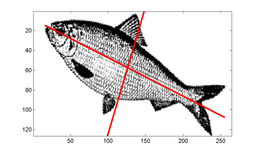

Под капотом он пытается разложить матрицу объект-признак $X$ на две матрицы поменьше:  $W$ и $\hat{W}$, минимизируя _среднеквадратичную ошибку (MSE)_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - матрица объектов (**центрированная**);
- $W \in \mathbb{R}^{m \times d}$ - матрица прямого преобразования;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - матрица обратного преобразования;
- $n$ количество образцов, $m$ исходное количество измерений и $d$ целевое количество измерений;


ЗАДАНИЕ: отобразите векторные представления слов в 2D плоскость с помощью PCA. Используем старый добрый sklearn api (fit, transform)
После этого, нормализуйте векторы, чтобы убедиться, что у них нулевое среднее и единичная дисперсия.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)
scaler = StandardScaler()
word_vectors_pca = scaler.fit_transform(word_vectors_pca)

In [ ]:
assert word_vectors_pca.shape == (len(word_vectors), 2), "there must be a 2d vector for each word"
assert max(abs(word_vectors_pca.mean(0))) < 1e-5, "points must be zero-centered"
assert max(abs(1.0 - word_vectors_pca.std(0))) < 1e-2, "points must have unit variance"

Давайте нарисуем это!

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

figure(id='p1004', ...)



---



#### 1.3.2 Визуализация соседей с помощью t-SNE

PCA — это хорошо, но он строго линеен и, следовательно, способен улавливать только грубую высокоуровневую структуру данных.

Если вместо этого мы хотим сосредоточиться на том, чтобы держать соседние точки рядом, мы можем использовать t-SNE. Здесь вы можете прочитать больше о [t-SNE](https://distill.pub/2016/misread-tsne/)

ЗАДАНИЕ: отобразим векторные представления слов на 2D плоскость с помощью t_SNE. Нормализуйте их так же, как и с PCA.

*не паникуйте, это может занять минуту или две для обучения*


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
word_tsne = tsne.fit_transform(word_vectors)
scaler = StandardScaler()
word_tsne = scaler.fit_transform(word_tsne)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)

figure(id='p1055', ...)



---



### 1.4 Эмбединги словосочетаний

Эмбединги слов также можно использовать для представления коротких фраз. Самый простой способ — взять среднее значение векторов для всех токенов во фразе с некоторыми весами.

Этот трюк полезен для определения того, с какими данными вы работаете: найти, есть ли какие-либо выбросы, кластеры или другие артефакты.

Давайте попробуем это на наших данных!

ЗАДАНИЕ: преобразуйте фразу в вектор, агрегируя ее векторные представления слов.

In [ ]:
def get_phrase_embedding(phrase):
    tokens = tokenizer.tokenize(phrase.lower())
    word_vectors = [model[word] for word in tokens if word in model]

    if not word_vectors:
        return np.zeros(model.vector_size, dtype='float32')

    vector = np.mean(word_vectors, axis=0)

    return vector


In [ ]:
vector = get_phrase_embedding("I'm very sure. This never happened to me before...")

assert np.allclose(vector[::10],
                   np.array([ 0.31807372, -0.02558171,  0.0933293 , -0.1002182 , -1.0278689 ,
                             -0.16621883,  0.05083408,  0.17989802,  1.3701859 ,  0.08655966],
                              dtype=np.float32))
assert np.array_equal(get_phrase_embedding("thisisgibberish"), np.zeros([model.vector_size], dtype='float32')), "corner case for all missing words should be handled as described in the function comments"

Давайте для начала рассмотрим только ~5k фраз.


In [ ]:
chosen_phrases = data[::len(data) // 1000]

ЗАДАНИЕ: вычислите векторы для выбранных фраз.

In [ ]:
phrase_vectors = np.array([get_phrase_embedding(phrase) for phrase in chosen_phrases])

In [ ]:
assert isinstance(phrase_vectors, np.ndarray) and np.isfinite(phrase_vectors).all()
assert phrase_vectors.shape == (len(chosen_phrases), model.vector_size)

Отобразите векторы в 2D пространство с помощью PCA, t-SNE или любого другого метода. Не забудьте нормализовать.

In [ ]:
phrase_vectors_2d = TSNE().fit_transform(phrase_vectors)

phrase_vectors_2d = (phrase_vectors_2d - phrase_vectors_2d.mean(axis=0)) / phrase_vectors_2d.std(axis=0)

In [ ]:
draw_vectors(phrase_vectors_2d[:, 0], phrase_vectors_2d[:, 1],
             phrase=[phrase[:50] for phrase in chosen_phrases],
             radius=20,)

figure(id='p1106', ...)



---



### 1.5 Поиск похожих вопросов

Наконец, давайте построим простой механизм "похожих вопросов" с использованием векторных представлений фраз, которые мы создали.

Посчитаем эмбединги всех фраз в датасете:

In [ ]:
data_vectors = np.array([get_phrase_embedding(l) for l in data])

ЗАДАНИЕ: реализуйте функцию для поиска похожих строк в данных.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_nearest(query, k=10):
    query_vector = get_phrase_embedding(query).reshape(1, -1)
    similarities = cosine_similarity(query_vector, data_vectors).flatten()
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return [data[i] for i in top_k_indices]


In [ ]:
results = find_nearest(query="How do i enter the matrix?", k=10)

print(''.join(results))

assert len(results) == 10 and isinstance(results[0], str)
assert results[0] == 'How do I get to the dark web?\n'
assert results[3] == 'What can I do to save the world?\n'

How do I get to the dark web?
What should I do to enter hollywood?
How do I use the Greenify app?
What can I do to save the world?
How do I win this?
How do I think out of the box? How do I learn to think out of the box?
How do I find the 5th dimension?
How do I use the pad in MMA?
How do I estimate the competition?
What do I do to enter the line of event management?



In [ ]:
find_nearest(query="How does Trump?", k=10)

['What does Donald Trump think about Israel?\n',
 'What books does Donald Trump like?\n',
 'What does Donald Trump think of India?\n',
 'What does India think of Donald Trump?\n',
 'What does Donald Trump think of China?\n',
 'What does Donald Trump think about Pakistan?\n',
 'What companies does Donald Trump own?\n',
 'What does Dushka Zapata think about Donald Trump?\n',
 'How does it feel to date Ivanka Trump?\n',
 'What does salesforce mean?\n']

In [ ]:
find_nearest(query="Why don't i ask a question myself?", k=10)

["Why don't I get a date?\n",
 "Why do you always answer a question with a question? I don't, or do I?\n",
 "Why can't I ask a question anonymously?\n",
 "Why don't I get a girlfriend?\n",
 "Why don't I have a boyfriend?\n",
 "I don't have no question?\n",
 "Why can't I take a joke?\n",
 "Why don't I ever get a girl?\n",
 "Can I ask a girl out that I don't know?\n",
 "Why don't I have a girlfriend?\n"]



---



### 1.6 Что дальше?


- Попробуйте запустить t-SNE на всех данных, а не только на 1000 фразах;
- Посмотрите, какие еще эмбедеры есть `gensim.downloader.info()`;
- Попробуйте [FastText](https://github.com/facebookresearch/fastText);
- Оптимизируйте `find_nearest` с помощью локально-чувствительного хеширования: используйте `nearpy` или `sklearn.neighbors`.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_vectors_tsne = tsne.fit_transform(data_vectors)


plt.figure(figsize=(10, 6))
plt.scatter(data_vectors_tsne[:, 0], data_vectors_tsne[:, 1], alpha=0.5, s=2)
plt.title("t-SNE проекция эмбеддингов фраз")
plt.show()

In [ ]:
import gensim.downloader as api

# Получаем информацию о доступных моделях
available_models = api.info()
print(available_models.keys())


In [ ]:
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors(n_neighbors=10, metric="cosine").fit(data_vectors)

def find_nearest_optimized(query, k=10):
    query_vector = get_phrase_embedding(query).reshape(1, -1)
    distances, indices = nn_model.kneighbors(query_vector, n_neighbors=k)

    return [data[i] for i in indices[0]]

results = find_nearest(query="How do i enter the matrix?", k=10)

print(''.join(results))

assert len(results) == 10 and isinstance(results[0], str)
assert results[0] == 'How do I get to the dark web?\n'
assert results[3] == 'What can I do to save the world?\n'




---



## Задание 2: мультиязычный машинный перевод на основе эмбеддингов (7 баллов)

В этой работе вы создадите систему машинного перевода, не используя большой корпус текста, alignment, attention, супер-крутые рекуррентные нейронные сети глубиной 100500 слоев и прочие подобные штуки.

Но даже без всего этого переводчик может быть достаточно хорошим (надеюсь).

Для нашей системы машинного перевода выбраны два родственных славянских языка: украинский и русский.

### 2.1 Фрагмент списка Сводеша для некоторых славянских языков

Список Сводеша - это лексикостатистическая штука. Он назван в честь американского лингвиста Морриса Сводеша и содержит базовую лексику. Этот список используется для определения подгрупп языков, степени их родства.

Таким образом, мы можем видеть некоторую инвариантность слов для разных славянских языков.



| Русский         | Белорусский              | Украинский               | Польский             | Чешский                         | Болгарский            |
|-----------------|--------------------------|-------------------------|--------------------|-------------------------------|-----------------------|
| женщина         | жанчына, кабета, баба    | жінка                   | kobieta            | žena                          | жена                  |
| мужчина         | мужчына                  | чоловік, мужчина        | mężczyzna          | muž                           | мъж                   |
| человек         | чалавек                  | людина, чоловік         | człowiek           | člověk                        | човек                 |
| ребёнок, дитя   | дзіця, дзіцёнак, немаўля | дитина, дитя            | dziecko            | dítě                          | дете                  |
| жена            | жонка                    | дружина, жінка          | żona               | žena, manželka, choť          | съпруга, жена         |
| муж             | муж, гаспадар            | чоловiк, муж            | mąż                | muž, manžel, choť             | съпруг, мъж           |
| мать, мама      | маці, матка              | мати, матір, неня, мама | matka              | matka, máma, 'стар.' mateř    | майка                 |
| отец, тятя      | бацька, тата             | батько, тато, татусь    | ojciec             | otec                          | баща, татко           |
| много           | шмат, багата             | багато                  | wiele              | mnoho, hodně                  | много                 |
| несколько       | некалькі, колькі         | декілька, кілька        | kilka              | několik, pár, trocha          | няколко               |
| другой, иной    | іншы                     | інший                   | inny               | druhý, jiný                   | друг                  |
| зверь, животное | жывёла, звер, істота     | тварина, звір           | zwierzę            | zvíře                         | животно               |
| рыба            | рыба                     | риба                    | ryba               | ryba                          | риба                  |
| птица           | птушка                   | птах, птиця             | ptak               | pták                          | птица                 |
| собака, пёс     | сабака                   | собака, пес             | pies               | pes                           | куче, пес             |
| вошь            | вош                      | воша                    | wesz               | veš                           | въшка                 |
| змея, гад       | змяя                     | змія, гад               | wąż                | had                           | змия                  |
| червь, червяк   | чарвяк                   | хробак, черв'як         | robak              | červ                          | червей                |
| дерево          | дрэва                    | дерево                  | drzewo             | strom, dřevo                  | дърво                 |
| лес             | лес                      | ліс                     | las                | les                           | гора, лес             |
| палка           | кій, палка               | палиця                  | patyk, pręt, pałka | hůl, klacek, prut, kůl, pálka | палка, пръчка, бастун |

Но контекстное распределение этих языков демонстрирует еще большую инвариантность. И мы можем использовать этот факт в наших целях.



---



### 2.2 Данные

In [1]:
import gensim
import numpy as np
from gensim.models import KeyedVectors

Скачайте эмбединги здесь:
* [cc.uk.300.vec.zip](https://yadi.sk/d/9CAeNsJiInoyUA)
* [cc.ru.300.vec.zip](https://yadi.sk/d/3yG0-M4M8fypeQ)

In [6]:
!unzip cc.uk.300.vec.zip -d /content


Archive:  cc.uk.300.vec.zip
  inflating: /content/cc.uk.300.vec  


In [5]:
!unzip cc.ru.300.vec.zip -d /content

Archive:  cc.ru.300.vec.zip
  inflating: /content/cc.ru.300.vec  


In [7]:
uk_emb = KeyedVectors.load_word2vec_format("cc.uk.300.vec")

In [8]:
ru_emb = KeyedVectors.load_word2vec_format("cc.ru.300.vec")

In [9]:
ru_emb.most_similar([ru_emb["август"]], topn=10)

[('август', 1.0000001192092896),
 ('июль', 0.9383152723312378),
 ('сентябрь', 0.9240029454231262),
 ('июнь', 0.9222574830055237),
 ('октябрь', 0.9095539450645447),
 ('ноябрь', 0.8930036425590515),
 ('апрель', 0.8729087114334106),
 ('декабрь', 0.8652557730674744),
 ('март', 0.8545795679092407),
 ('февраль', 0.8401415944099426)]

In [10]:
uk_emb.most_similar([uk_emb["серпень"]])

[('серпень', 0.9999998807907104),
 ('липень', 0.9096441268920898),
 ('вересень', 0.9016969203948975),
 ('червень', 0.8992518782615662),
 ('жовтень', 0.8810408115386963),
 ('листопад', 0.8787633180618286),
 ('квітень', 0.8592804670333862),
 ('грудень', 0.8586863279342651),
 ('травень', 0.840811014175415),
 ('лютий', 0.8256431221961975)]

In [11]:
ru_emb.most_similar([uk_emb["серпень"]])

[('Недопустимость', 0.24435284733772278),
 ('конструктивность', 0.23293082416057587),
 ('офор', 0.23256804049015045),
 ('deteydlya', 0.230317160487175),
 ('пресечении', 0.22632381319999695),
 ('одностороннего', 0.22608886659145355),
 ('подход', 0.2230587750673294),
 ('иболее', 0.22003726661205292),
 ('2015Александр', 0.21872766315937042),
 ('конструктивен', 0.21796567738056183)]

Загрузите небольшие словари для соответствующих пар слов в качестве обучающего и тестового наборов.

In [12]:
def load_word_pairs(filename):
    uk_ru_pairs = []
    uk_vectors = []
    ru_vectors = []
    with open(filename, "r") as inpf:
        for line in inpf:
            uk, ru = line.rstrip().split("\t")
            if uk not in uk_emb or ru not in ru_emb:
                continue
            uk_ru_pairs.append((uk, ru))
            uk_vectors.append(uk_emb[uk])
            ru_vectors.append(ru_emb[ru])
    return uk_ru_pairs, np.array(uk_vectors), np.array(ru_vectors)

In [18]:
!gdown 1_6zH4Ca-UQPZcjh4okpUetXAsu4c1e4O

Downloading...
From: https://drive.google.com/uc?id=1_6zH4Ca-UQPZcjh4okpUetXAsu4c1e4O
To: /content/dl-9.zip
100% 26.0k/26.0k [00:00<00:00, 55.7MB/s]


In [23]:
!unzip dl-9.zip -d /content

Archive:  dl-9.zip
   creating: /content/dl-9/
  inflating: /content/dl-9/fairy_tale.txt  
  inflating: /content/__MACOSX/dl-9/._fairy_tale.txt  
  inflating: /content/dl-9/ukr_rus.test.txt  
  inflating: /content/__MACOSX/dl-9/._ukr_rus.test.txt  
  inflating: /content/dl-9/ukr_rus.train.txt  
  inflating: /content/__MACOSX/dl-9/._ukr_rus.train.txt  


In [24]:
uk_ru_train, X_train, Y_train = load_word_pairs("/content/dl-9/ukr_rus.train.txt")

In [28]:
uk_ru_test, X_test, Y_test = load_word_pairs("/content/dl-9/ukr_rus.test.txt")



---



### 2.3 Embedding mapping

Пусть $x_i \in \mathrm{R}^d$ будет представлением слова $i$ в исходном языке, а $y_i \in \mathrm{R}^d$ - векторным представлением его перевода. Наша цель - обучить такое линейное преобразование $W$, которое минимизирует евклидово расстояние между $Wx_i$ и $y_i$ для некоторого подмножества эмбеддингов.


Таким образом, мы можем сформулировать так называемую [проблему Прокруста](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem):

$$W^*= \arg\min_W \sum_{i=1}^n||Wx_i - y_i||_2$$
или
$$W^*= \arg\min_W ||WX - Y||_F$$

где $||*||_F$ - норма Фробениуса.

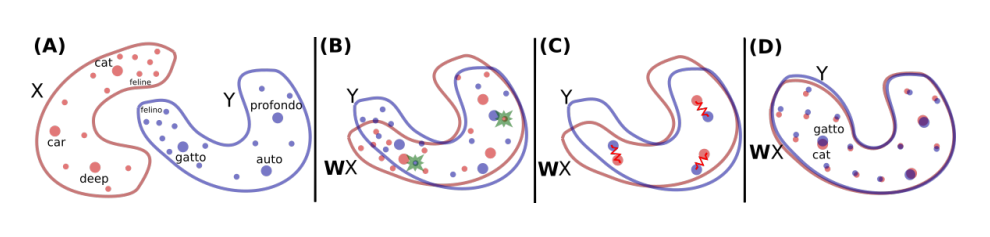

В греческой мифологии Прокруст, или "растягиватель", был злодеем-кузнецом и разбойником из Аттики, который нападал на людей, растягивая их или отрезая им ноги, чтобы заставить их соответствовать размеру железной кровати. Мы делаем те же плохие вещи с пространством векторных представлений исходного языка. Наше ложе Прокруста - это пространство векторных представлений целевого языка.

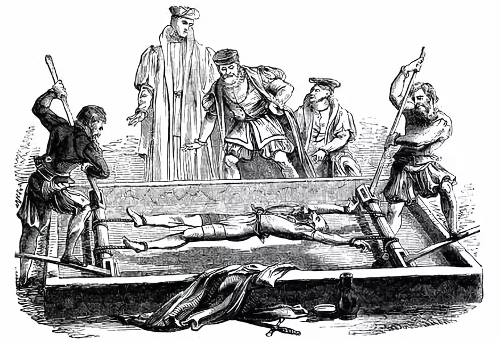

Но подождите...

$W^*= \arg\min_W \sum_{i=1}^n||Wx_i - y_i||_2$ выглядит как простая множественная линейная регрессия (без свободного члена) :)))


ЗАДАНИЕ: реализуйте вышеописанное преобразование.

In [29]:
from sklearn.linear_model import LinearRegression


mapping = LinearRegression()
mapping.fit(X_train, Y_train)


LinearRegression()

Давайте взглянем на соседей слова "_серпень_" ("август" по-русски) после линейного преобразования.

In [30]:
august = mapping.predict(uk_emb["серпень"].reshape(1, -1))
ru_emb.most_similar(august)

[('апрель', 0.8541592955589294),
 ('июнь', 0.8411964178085327),
 ('март', 0.8397400379180908),
 ('сентябрь', 0.8359215259552002),
 ('февраль', 0.8328748941421509),
 ('октябрь', 0.8311805725097656),
 ('ноябрь', 0.8278146982192993),
 ('июль', 0.8236351013183594),
 ('август', 0.8120613098144531),
 ('декабрь', 0.8038000464439392)]

Окрестность этого векторного представления состоит из разных месяцев, но правильный вариант находится на девятом месте.



---



### 2.4 Оценка качества


В качестве меры качества мы будем использовать precision top-1, top-5 и top-10 (для каждого преобразованного украинского эмбеддинга мы считаем, сколько правильных пар целевых слов найдено в top N ближайших соседях в пространстве векторных представлений русского языка)

ЗАДАНИЕ: реализуйте оценку качества

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

def precision(pairs, mapped_vectors, topn=1):
    """
    :args:
        pairs = list of right word pairs [(uk_word_0, ru_word_0), ...]
        mapped_vectors = list of embeddings after mapping from source embedding space to destination embedding space
        topn = the number of nearest neighbours in destination embedding space to choose from
    :returns:
        precision_val, float number, total number of words for those we can find right translation at top K.
    """
    assert len(pairs) == len(mapped_vectors)
    num_matches = 0

    ru_words = list(ru_emb.index_to_key)
    ru_vectors = np.array([ru_emb[word] for word in ru_words])

    for i, (_, ru) in enumerate(pairs):
        query_vector = mapped_vectors[i].reshape(1, -1)
        similarities = cosine_similarity(query_vector, ru_vectors)
        nearest_ids = similarities.argsort()[0][-topn:][::-1]

        nearest_words = [ru_words[idx] for idx in nearest_ids]
        if ru in nearest_words:
            num_matches += 1

    precision_val = num_matches / len(pairs)
    return precision_val

In [35]:
assert precision([("серпень", "август")], august, topn=5) == 0.0
assert precision([("серпень", "август")], august, topn=9) == 1.0
assert precision([("серпень", "август")], august, topn=10) == 1.0

In [36]:
assert precision(uk_ru_test, X_test) == 0.0
assert precision(uk_ru_test, Y_test) == 1.0

In [ ]:
precision_top1 = precision(uk_ru_test, mapping.predict(X_test), 1)
precision_top5 = precision(uk_ru_test, mapping.predict(X_test), 5)

assert precision_top1 >= 0.635
assert precision_top5 >= 0.813



---



### 2.5 Можно лучше: ортогональная проблема Прокруста

Можно показать (см. [оригинальную статью](https://www.researchgate.net/publication/257678911_JC_Gower_and_GB_DijksterhuisProcrustes_problems_New_York_Oxford_University_Press)), что согласованное линейное отображение между семантическими пространствами должно быть ортогональным.
Мы можем наложить ограничения на преобразование $W$ - оно должно быть ортогональным.


Тогда мы будем решать следующую задачу:

$$W^*= \arg\min_W ||WX - Y||_F \text{, где: } W^TW = I$$

$$I \text{- единичная матрица}$$


Вместо того, чтобы решать еще одну задачу регрессии, мы можем найти оптимальное ортогональное преобразование, используя сингулярное разложение. Оказывается, что оптимальное преобразование $W^*$ может быть выражено через компоненты `SVD`:

$$X^TY=U\Sigma V^T\text{, сингулярное разложение}$$
$$W^*=UV^T$$

ЗАДАНИЕ: реализуйте вышеописанное преобразование.

In [38]:
def learn_transform(X_train, Y_train):
    U, _, Vt = np.linalg.svd(X_train.T @ Y_train)
    W = U @ Vt

    return W

In [39]:
W = learn_transform(X_train, Y_train)

In [40]:
ru_emb.most_similar([np.matmul(uk_emb["серпень"], W)])

[('апрель', 0.8237906694412231),
 ('сентябрь', 0.8049713373184204),
 ('март', 0.8025653958320618),
 ('июнь', 0.8021842241287231),
 ('октябрь', 0.8001735806465149),
 ('ноябрь', 0.7934483289718628),
 ('февраль', 0.7914120554924011),
 ('июль', 0.7908109426498413),
 ('август', 0.7891016602516174),
 ('декабрь', 0.7686373591423035)]

In [41]:
assert precision(uk_ru_test, np.matmul(X_test, W)) >= 0.653
assert precision(uk_ru_test, np.matmul(X_test, W), 5) >= 0.824



---



### 2.6 UK-RU Переводчик

Теперь мы готовы сделать простой word-based переводчик: для каждого слова в исходном языке в общем пространстве векторных представлений мы находим ближайшее слово в целевом языке.

In [42]:
with open("/content/dl-9/fairy_tale.txt", "r") as inpf:
    uk_sentences = [line.rstrip().lower() for line in inpf]

ЗАДАНИЕ: реализуйте переводчик.

In [45]:
def translate(sentence):
    translated_words = []

    for word in sentence.split():
        if word in uk_emb:
            uk_vector = uk_emb[word].reshape(1, -1)
            ru_vector = uk_vector @ W
            nearest_word = ru_emb.most_similar(ru_vector, topn=1)[0][0]
            translated_words.append(nearest_word)
        else:
            translated_words.append(word)

    return " ".join(translated_words)


In [46]:
assert translate(".") == "."
assert translate("1 , 3") == "1 , 3"
assert translate("кіт зловив мишу") == "кот поймал мышку"

In [47]:
for sentence in uk_sentences:
    print("src: {}\ndst: {}\n".format(sentence, translate(sentence)))

src: лисичка - сестричка і вовк - панібрат
dst: лисичка – сестричка и волк – панібрат

src: як була собі лисичка та зробила хатку, та й живе. а це приходять холоди. от лисичка замерзла та й побігла в село вогню добувать, щоб витопити. прибігає до одної баби та й каже:
dst: как была себе лисичка и сделала хатку, и и живе. а оно приходят холоди. из лисичка замерзла и и побежала во село огня добувать, чтобы витопити. прибегает к одной бабы и и каже:

src: — здорові були, бабусю! з неділею... позичте мені огню, я вам одслужу.
dst: — здоровые були, бабусю! со неділею... позичте мне огню, мной тебе одслужу.

src: — добре, — каже, — лисичко - сестричко. сідай погрійся трохи, поки я пиріжечки повибираю з печі!
dst: — добре, — каже, — лисичко – сестричко. садись погрійся трохи, пока мной пирожки повибираю со печі!

src: а баба макові пиріжки пекла. от баба вибирає пиріжки та на столі кладе, щоб прохололи; а лисичка підгляділа та за пиріг, та з хати... виїла мачок із середини, а туди напхала смі

Не так уж и плохо, правда? Мы можем легко улучшить перевод, используя языковую модель и не одного, а нескольких ближайших соседей в общем пространстве векторных представлений. Но в следующий раз.



---



### 2.7 Хотите узнать больше?

**Статьи:**
* [Exploiting Similarities among Languages for Machine Translation](https://arxiv.org/pdf/1309.4168)  - отправная точка для исследований многоязычных векторных представлений от Томаша Миколова (автора Word2Vec)
* [Offline bilingual word vectors, orthogonal transformations and the inverted softmax](https://arxiv.org/pdf/1702.03859) - ортогональное преобразование для unsupervised машинного перевода
* [Word Translation Without Parallel Data](https://arxiv.org/pdf/1710.04087)
* [Loss in Translation: Learning Bilingual Word Mapping with a Retrieval Criterion](https://arxiv.org/pdf/1804.07745)
* [Unsupervised Alignment of Embeddings with Wasserstein Procrustes](https://arxiv.org/pdf/1805.11222)


**Репозитории (с готовыми к использованию многоязычными векторными представлениями):**

* https://github.com/facebookresearch/MUSE

* https://github.com/Babylonpartners/fastText_multilingual



---



# Домашнее задание № 9

Выполните все задания в этом ноутбуке.

+ Мягкий дедлайн: `06.04.25 23:59`
+ Жесткий дедлайн: `13.04.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.